In [2]:
import pandas as pd #数据分析
import numpy as np #科学计算
 
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

sns.set_style("whitegrid") 
%matplotlib inline

In [3]:
## 模型训练策略的开关
WITH_MISSING_VALUES = True
FIXED_CABIN_BY_TICKET_GROUP = False
FIXED_CABIN_BY_TICKET_AND_SURNAME = True

In [163]:
def dealWithNameFeature(dataset):
    # get Title feature
    dataset['Title'] = dataset.Name.apply(lambda x:getTitle(x))
    # get Surname feature
    dataset['Surname'] = dataset.Name.apply(lambda x: x.split(',')[0].strip())

def getSurnameGroupId(dataset): 
    dataset['SurnameGroupId'] = dataset.apply(lambda row : str(row.Surname + '-' + str(row.Pclass) + '-' + str(row.Embarked) + '-' + str(row.Fare) + '-' + row.Ticket[:-2] + '__'), axis = 1)

def getTicketGroupId(dataset):    
    dataset['TicketGroupId'] = dataset.apply(lambda row : str(str(row.Pclass) + '-' + str(row.Embarked) + '-' + str(row.Fare) + '-' + row.Ticket), axis = 1)

def getSurnameGroupSize(dataset): 
    surname_group_value_count = dataset.SurnameGroupId.value_counts()
    dataset['SurnameGroupSize'] = dataset.apply(lambda row : surname_group_value_count.loc[row.SurnameGroupId], axis=1)
    
def addNanniesCousinsFriends(dataset, only_boy_female = False, verbose = False):
    '''
    @dataset
    @only_boy_female: only adding solo boys and females to surname groups if only_boy_female is True
                otherwise: adding solo passengers to surname groups
    '''
    if only_boy_female:
        solo_passengers = dataset.loc[(dataset.SurnameGroupSize == 1) & (index_boy | index_female)]
    else:
        solo_passengers = dataset.loc[(dataset.SurnameGroupSize == 1)]
    if verbose:
        print('Tottaly %d solo passengers satifies the condtions' % solo_passengers.shape[0])
    nannies_cousins_firends = set()
    count_nannies_cousins_firends = 0
    for index, solo_passenger in solo_passengers.iterrows():
        items = dataset.loc[(dataset.TicketGroupId == solo_passenger.TicketGroupId) & (dataset.PassengerId != solo_passenger.PassengerId)]
        if items.shape[0] > 0:
            count_nannies_cousins_firends += 1
            nannies_cousins_firends.add(solo_passenger.SurnameGroupId)
            nannies_cousins_firends.add(items.iloc[0,:].SurnameGroupId)
            dataset.loc[dataset.PassengerId == solo_passenger.PassengerId, 'SurnameGroupId'] = items.iloc[0,:].SurnameGroupId
    if verbose:
        print('Totally adding %d  nannies, cousins and firends to surname groups' % count_nannies_cousins_firends)
    return nannies_cousins_firends
        
def engineeringFeatures(dataset = None, verbose = False):
    dealWithNameFeature(dataset)
    getSurnameGroupId(dataset)
    getTicketGroupId(dataset)
    getSurnameGroupSize(dataset)
    addNanniesCousinsFriends(dataset, verbose = verbose, only_boy_female=True)
    # resize the surname group size 
    getSurnameGroupSize(dataset)
    
def getSurnameGroupSurvived(dataset, indicies_train_set):
    '''
    get the 'SurnameGroupSurvived' feature in train set 
    @dataset : combination of train set and test set 
    @indices_train : indices of train set 
    '''
    dataset['SurnameGroupSurvived'] = np.NaN
    surname_group_survived_mean = dataset.loc[indicies_train_set, ['SurnameGroupId','Survived']].groupby(['SurnameGroupId']).Survived.mean()
    dataset.loc[indicies_train_set, ['SurnameGroupSurvived']] = dataset.loc[indicies_train_set,'SurnameGroupId'].apply(lambda x: surname_group_survived_mean.loc[x])
    
def setSurnameGroupSurvivedInTestSet(dataset, indices_test_set):
    '''
    set the 'SurnameGroupSurvived' feature in test set 
    @dataset : combination of train set and test set 
    @indices_test_set : indices of test set 
    ''' 
    for idx in indices_test_set:
        tmp = dataset.loc[(dataset.SurnameGroupId == dataset.loc[idx, 'SurnameGroupId']) & (dataset.SurnameGroupSurvived.notnull()), ['SurnameGroupSurvived']]
        if tmp.shape[0] > 0:
            dataset.loc[idx, 'SurnameGroupSurvived'] = tmp.values[0]
        if (pd.isna(dataset.loc[idx, 'SurnameGroupSurvived'])):
            if dataset.loc[idx, 'Pclass']  == 3:
                dataset.loc[idx, 'SurnameGroupSurvived'] = 1.0
            else:
                dataset.loc[idx, 'SurnameGroupSurvived'] = 0.0

def getWomanChildrenGroupSurvived(dataset, indicies_train_set):
    '''
    get the 'SurnameGroupSurvived' feature in train set
    @dataset : combination of train set and test set
    @indices_train : indices of train set
    '''
    dataset['WomanChildGroupSurvived'] = np.NaN
    indices_female = (dataset.Sex == 'female') 
    indices_boy = (dataset.Title == 'Master') | ((dataset.Sex == 'male') & (dataset.Age <= children_age_upper_limit))
    indices_WCG = (dataset.SurnameGroupSize > 1) & (indices_female | indices_boy)
    
    # Not to group sb, according to analysis above
    dataset['WomanChildGroupId'] = dataset.SurnameGroupId
    dataset.loc[~indices_WCG, 'WomanChildGroupId'] = 'NoGroup'  
    
    ## woman-child-group 
    woman_child_group_survived_mean = dataset.loc[indicies_train_set, ['WomanChildGroupId','Survived']].groupby(['WomanChildGroupId']).Survived.mean()
    dataset.loc[indicies_train_set, 'WomanChildGroupSurvived'] = dataset.loc[indicies_train_set, 'WomanChildGroupId'].apply(lambda x: woman_child_group_survived_mean.loc[x])
    
    
def setWomenChildGroupSurvivedInTestSet(dataset, indices_test_set):
    '''
    set the 'SurnameGroupSurvived' feature in test set
    @dataset : combination of train set and test set
    @indices_test_set : indices of test set
    '''
    for idx in indices_test_set:
        tmp = dataset.loc[(dataset.WomanChildGroupId == dataset.loc[idx,'WomanChildGroupId']) & (dataset.WomanChildGroupSurvived.notnull()), 'WomanChildGroupSurvived'] 
        if tmp.shape[0] > 0:
            dataset.loc[idx, 'WomanChildGroupSurvived'] = tmp.values[0]
        if (pd.isna(dataset.loc[idx, 'WomanChildGroupSurvived'])):
            if dataset.loc[idx, 'Pclass'] == 3:
                dataset.loc[idx, 'WomanChildGroupSurvived'] = 0
            else:
                dataset.loc[idx, 'WomanChildGroupSurvived'] = 1

def predictionByWomanBoyRules(dataset):
    '''
    the results of prediction stored in 'Predict' feature in the dataset
    @dataset : combination of train set and test set
    '''
    indices_female = (dataset.Sex == 'female') 
    indices_boy = (dataset.Title == 'Master') | ((dataset.Sex == 'male') & (dataset.Age <= children_age_upper_limit))
    indices_male_adult = (all_data.SurnameGroupSize > 1) & (~index_boy) & (all_data.Sex == 'male')
    
    dataset['Predict'] = 0.0
    dataset.loc[index_female, 'Predict'] = 1.0
    dataset.loc[(dataset.WomanChildGroupSurvived == 0.0) & index_female & (dataset.SurnameGroupSize > 1), 'Predict'] = 0.0
    dataset.loc[(dataset.WomanChildGroupSurvived == 1.0) & index_boy & (dataset.SurnameGroupSize > 1), 'Predict'] = 1.0
    
    #dataset.loc[index_female | index_boy, 'Predict'] = 1.0
    #dataset.loc[(dataset.WomanChildGroupSurvived == 0.0) & (index_female | index_boy) & (dataset.SurnameGroupSize > 1), 'Predict'] = 0.0
    #dataset.loc[indices_male_adult & (dataset.SurnameGroupSurvived == 1) & (dataset.Pclass == 1), 'Predict'] = 1.0
    
    
    return dataset

## 读取数据

In [5]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

all_data = pd.concat([train, test], ignore_index = True)

In [6]:
train = pd.read_csv("./data/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


字段有：
1. Passengerld => 乘客ID 
2. Pclass => 乘客等级(1/2/3等舱位) 
3. Name => 乘客姓名 
4. Sex => 性别 
5. Age => 年龄 
6. SibSp => 堂兄弟/妹个数 
7. Parch => 父母与小孩个数 
8. Ticket => 船票信息 
9. Fare => 票价 
10. Cabin => 客舱 
11. Embarked => 登船港口

### 查看数据集基本信息

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 查看缺失数据

In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

训练数据总共有891名乘客，但是很不幸，我们有些属性的数据不全
1. Age(年龄)属性只有714名乘客有记录 
2. Cain(客舱)只有204名乘客是已知的；
3. Embarked 属性只缺2个

看看测试数据

In [9]:
test.info()
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

测试数据中总共有481名乘客
1. 有更多缺失值Age(年龄)：86个缺失
2. Fare属性缺1位乘客的信息 
3. Cabin(客舱)只有91名乘客是已知的；

In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [11]:
all_data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

### 查看特征的分布信息

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [14]:
all_data.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


**<font color="red">查看特征与标签关系</font>**

### Fare

In [15]:
ticket_value_counts = dict(all_data.Ticket.value_counts())

In [16]:
all_data['TicketSize'] = all_data.Ticket.apply(lambda x : ticket_value_counts[x])

In [17]:
all_data['SingleTicketFare'] = all_data.apply(lambda row : row.Fare / row.TicketSize, axis = 1)

In [18]:
all_data['SingleTicketFare'].head()

0     7.25000
1    35.64165
2     7.92500
3    26.55000
4     8.05000
Name: SingleTicketFare, dtype: float64

In [19]:
train = all_data.iloc[:train.shape[0]]
test = all_data.iloc[train.shape[0]]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                 Survived
CategoricalFare          
(-0.001, 6.238]  0.300000
(6.238, 7.245]   0.244898
(7.245, 7.775]   0.302752
(7.775, 7.925]   0.255556
(7.925, 8.872]   0.214286
(8.872, 13.0]    0.403614
(13.0, 25.576]   0.500000
(25.576, 30.0]   0.673469
(30.0, 128.082]  0.622449


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


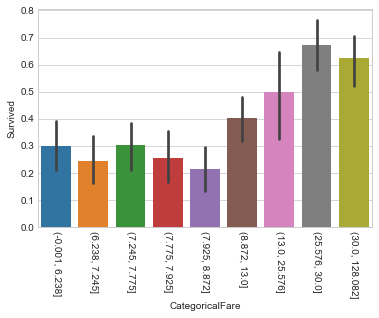

In [20]:

train['CategoricalFare'] = pd.qcut(train['SingleTicketFare'], 9)
fare_survived = train.loc[:, ['CategoricalFare', 'Survived']].groupby(['CategoricalFare']).mean()
print(fare_survived)
plt.xticks(rotation=270)
plt.rcParams['figure.figsize'] =(5, 5)
sns.barplot(x='CategoricalFare', y='Survived', data=train)
train.drop(['CategoricalFare'], axis = 1, inplace=True)

### Sex

电影里面，援救过程中：女士，小孩优先

In [21]:
print(train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


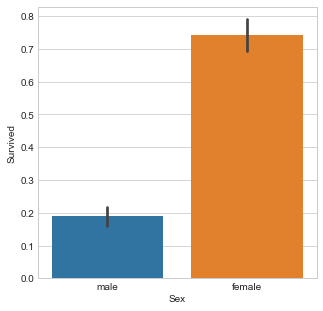

In [22]:
sns.barplot(x="Sex", y="Survived", data=train)

In [23]:
train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

也就是说，依据性别全部判断女性幸存，男性遇难，训练集正确率都有 

$$\big[577 \times (1 - 0.188908) + 314 \times 0.742038\big] / 891 = 78.67\%$$

当然这只是训练数据。

### Age

由前面可知，Age缺失严重，但是不妨碍我们根据女士儿童优先探索一下，年龄分段到底影响结果与否？

In [24]:
children_age_upper_limit = 12
def getAgeSegment(age):
    age_seg = 5
    if age <= children_age_upper_limit:
        age_seg = 1 # aldolescents
    elif age <= 32 :
        age_seg = 2
    elif age <= 48 :
        age_seg = 3
    elif age <= 65 : # almost retirement age
        age_seg = 4

    return np.int32(age_seg)

In [25]:
AgeNotNull = train.loc[train.Age.notnull(), ['Age', 'Survived', 'Sex']]
AgeNotNull.head()

,Age,Survived,Sex
0,22.0,0.0,male
1,38.0,1.0,female
2,26.0,1.0,female
3,35.0,1.0,female
4,35.0,0.0,male


In [26]:
AgeNotNull.Age = AgeNotNull.Age.apply(lambda x: getAgeSegment(x))
AgeNotNull.head(10)

,Age,Survived,Sex
0,2,0.0,male
1,3,1.0,female
2,2,1.0,female
3,3,1.0,female
4,3,0.0,male
6,4,0.0,male
7,1,0.0,male
8,2,1.0,female
9,2,1.0,female
10,1,1.0,female


In [27]:
AgeNotNull.groupby(by='Age', as_index=False).mean()

,Age,Survived
0,1,0.579710
1,2,0.379310
2,3,0.404255
3,4,0.416667
4,5,0.125000


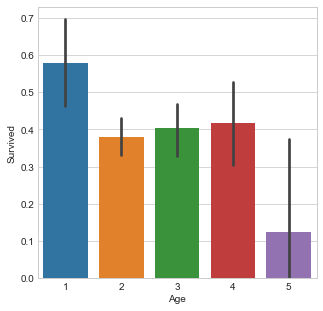

In [28]:
sns.barplot(x='Age', y='Survived', data = AgeNotNull)

In [29]:
AgeNotNull.groupby(by=['Age', 'Sex'], as_index=False).mean()

,Age,Sex,Survived
0,1,female,0.593750
1,1,male,0.567568
2,2,female,0.744526
3,2,male,0.170833
4,3,female,0.794118
5,3,male,0.183333
6,4,female,0.916667
7,4,male,0.166667
8,5,male,0.125000


由上表我们观察到：
1. 只要是女的，幸存率都很高
2. 男的里面属于最小年龄段的幸存率是其他段的3倍多，其他年龄段男生直接预测死亡，准确率都有 $80\%$ 出头

<label align='center'><h3> 目标 </h3></label>

那么我们得出这样的<font color='red'>**目标**</font>：<font color='blue'><strong>默认预测女性都存活，男性都遇难，再加上以下：</strong></font>

1. <font color='blue'>预测什么样的女性会遇难，毕竟少数，如果能够预测对，正确率就会极大提高。</font>

2. <font color='blue'>预测什么样的男孩（最小年龄段的男性）会幸存，也是少数，如果能够预测对，正确率就会极大提高。</font>

3. <font color='blue'>不是第一个年龄段的男性什么条件下会存活？</font>


### Name

In [30]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name特征含3个字段：
1. 姓氏
2. 称谓Title
3. 名字

#### 提取称谓字段Title 

In [31]:
import re as re # 正则包提取

def getTitle(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

all_data['Title'] = all_data['Name'].apply(getTitle)

##### Master

启发于 [Chris Deotte](https://www.kaggle.com/cdeotte) 的kernel: [Titanic using Name only [0.81818]
](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818)，于是探索了一下，`Master` 有何特点？

In [32]:
Title_Master_DataFrame = all_data.loc[all_data['Title']=='Master']

In [33]:
Title_Master_DataFrame.Sex.value_counts()

male    61
Name: Sex, dtype: int64

`Master`全是男的

In [34]:
Title_Master_DataFrame.Age.value_counts()

2.00     5
4.00     5
1.00     5
9.00     5
6.00     4
3.00     4
7.00     3
8.00     3
13.00    3
0.83     3
11.00    2
10.00    2
11.50    1
0.75     1
14.50    1
5.00     1
12.00    1
0.33     1
0.42     1
0.92     1
0.67     1
Name: Age, dtype: int64

`Master`全是小于15岁的

In [35]:
Title_Master_DataFrame.Survived.value_counts()

1.0    23
0.0    17
Name: Survived, dtype: int64

我们看看是不是所有的男孩都叫 `Master`:

In [36]:
np.sum(all_data.Title == 'Master')

61

In [37]:
boy = all_data.loc[(all_data.Age <= children_age_upper_limit) & (all_data.Sex == 'male')]
boy.shape[0]

50

In [38]:
np.sum(boy.Title == 'Master')

49

In [39]:
boy.loc[boy.Title != 'Master']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TicketSize,SingleTicketFare,Title
731,11.0,NaN,C,18.7875,"Hassan, Mr. Houssein G N",0,732,3,male,0,0.0,2699,2,9.39375,Mr


In [40]:
all_data.loc[all_data.Name.str.contains('Hassan')] 

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TicketSize,SingleTicketFare,Title
731,11.0,NaN,C,18.7875,"Hassan, Mr. Houssein G N",0,732,3,male,0,0.0,2699,2,9.39375,Mr


In [41]:
all_data.loc[all_data.Ticket.str.match('^2699$')] 

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TicketSize,SingleTicketFare,Title
207,26.0,NaN,C,18.7875,"Albimona, Mr. Nassef Cassem",0,208,3,male,0,1.0,2699,2,9.39375,Mr
731,11.0,NaN,C,18.7875,"Hassan, Mr. Houssein G N",0,732,3,male,0,0.0,2699,2,9.39375,Mr


无法确定他们是不是亲戚关系？如果不是就是这个11岁小男孩单独出行。

##### Title的性别分布

In [42]:
all_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [43]:
a_set = set(["Dona",'the Countess','Mme',"Mlle","Ms","Miss","Lady","Mrs", 'Countess'])
tmp_dict = {'female': 0}
for item in a_set:
    new_dict = dict(all_data.loc[all_data.Title == item, :].Sex.value_counts())
    print(item, new_dict)
    if 'female' in set(new_dict.keys()):
        tmp_dict['female'] +=new_dict['female'] 
    
all_data.loc[all_data.Sex == 'female'].shape[0], tmp_dict['female'] 

the Countess {}
Miss {'female': 260}
Mme {'female': 1}
Countess {'female': 1}
Mrs {'female': 197}
Lady {'female': 1}
Mlle {'female': 2}
Dona {'female': 1}
Ms {'female': 2}


(466, 465)

少了一位女性？看看以下：

In [44]:
a_set = set(["Capt","Don","Major","Col","Rev","Dr","Sir","Mr","Jonkheer",'Master'])

tmp_dict = {'male': 0}
for item in a_set:
    new_dict = dict(all_data.loc[all_data.Title == item, :].Sex.value_counts())
    print(item, new_dict)
    if 'male' in set(new_dict.keys()):
        tmp_dict['male'] +=new_dict['male'] 
    
all_data.loc[all_data.Sex == 'male'].shape[0], tmp_dict['male'] 

Major {'male': 2}
Col {'male': 4}
Capt {'male': 1}
Master {'male': 61}
Sir {'male': 1}
Rev {'male': 8}
Dr {'male': 7, 'female': 1}
Mr {'male': 757}
Jonkheer {'male': 1}
Don {'male': 1}


(843, 843)

这里有一位女Dr。

**前文我们已经看到女性幸存率和男孩较高，这里我们提取他们的位置：**

In [45]:
index_female = (all_data.Sex == 'female')

index_boy = ((all_data.Title == 'Master') | ((all_data.Age <= children_age_upper_limit) & (all_data.Sex == 'male')))

#### 提取姓氏字段 Surname

In [46]:
all_data['Surname']=all_data['Name'].apply(lambda x:x.split(',')[0].strip())

#### 提取FamilySize

按姓氏统计的家族成员数，这里属于**粗粒度划分**，因为不同家庭同姓氏也是有可能的！

<font color='red'>**为什么要统计家庭成员？**</font>
有句老话：在家靠父母，出门靠朋友。在援救过程中，势必一起出行的人或多或少会互相帮助，那么对生存预测就有影响。

In [47]:
Surname_Count = dict(all_data['Surname'].value_counts()) 
all_data['FamilySize'] = all_data['Surname'].apply(lambda x:Surname_Count[x])

In [48]:
test = all_data.iloc[train.shape[0]:, :]
train = all_data.iloc[:train.shape[0], :]
train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TicketSize,SingleTicketFare,Title,Surname,FamilySize
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,7.25000,Mr,Braund,2
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,35.64165,Mrs,Cumings,2
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,7.92500,Miss,Heikkinen,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,26.55000,Mrs,Futrelle,2
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,8.05000,Mr,Allen,2


In [49]:
all_data.loc[all_data.FamilySize > 2, :].sort_values(['Surname', 'Fare', 'Ticket']).shape[0]

406

**姓氏一共多少种？**

In [50]:
len(all_data.Surname.unique()), len(train.Surname.unique()), len(test.Surname.unique())

(875, 667, 352)

#### 同姓却是不同家庭

启发于：[Erik Bruin](https://www.kaggle.com/erikbruin) 的kernel: [Titanic: 2nd degree families and majority voting](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting)

In [51]:
data_frame = all_data.groupby(['Surname', 'Ticket', 'Fare', 'Pclass', 'Embarked', 'Name', 'Age', 'SibSp', 'Parch'])[ 'Survived'].count().to_frame()
data_frame.head(10)

Survived
Surname     Ticket           Fare    Pclass Embarked Name                                      Age  SibSp Parch          
Abbing      C.A. 5547        7.5500  3      S        Abbing, Mr. Anthony                       42.0 0     0             1
Abbott      C.A. 2673        20.2500 3      S        Abbott, Master. Eugene Joseph             13.0 0     2             0
                                                     Abbott, Mr. Rossmore Edward               16.0 1     1             1
                                                     Abbott, Mrs. Stanton (Rosa Hunt)          35.0 1     1             1
Abelseth    348122           7.6500  3      S        Abelseth, Mr. Olaus Jorgensen             25.0 0     0             0
            348125           7.6500  3      S        Abelseth, Miss. Karen Marie               16.0 0     0             0
Abelson     P/PP 3381        24.0000 2      C        Abelson, Mr. Samuel                       30.0 1     0             1
                                                     Abelson, Mrs. Samuel (Hannah Wizosky)     28.0 1     0             1
Abrahamsson SOTON/O2 3101284 7.9250  3      S        Abrahamsson, Mr. Abraham August Johannes  20.0 0     0             0
Abrahim     2657             7.2292  3      C        Abrahim, Mrs. Joseph (Sophie Halaut Easu) 18.0 0     0             0

**例1：姓氏为Andersson的乘客**

In [52]:
tmp = data_frame.loc[['Andersson']]
tmp.sort_index(level=[0, 2])

Survived
Surname   Ticket  Fare    Pclass Embarked Name                                               Age  SibSp Parch          
Andersson 347075  7.7750  3      S        Andersson, Mr. Johan Samuel                        26.0 0     0             0
          347091  7.7750  3      S        Andersson, Miss. Ida Augusta Margareta             38.0 4     2             0
          350043  7.7958  3      S        Andersson, Mr. August Edvard ("Wennerstrom")       27.0 0     0             1
          3101281 7.9250  3      S        Andersson, Miss. Erna Alexandra                    17.0 4     2             1
          347082  31.2750 3      S        Andersson, Master. Sigvard Harald Elias            4.0  4     2             1
                                          Andersson, Miss. Ebba Iris Alfrida                 6.0  4     2             1
                                          Andersson, Miss. Ellis Anna Maria                  2.0  4     2             1
                                          Andersson, Miss. Ingeborg Constanzia               9.0  4     2             1
                                          Andersson, Miss. Sigrid Elisabeth                  11.0 4     2             1
                                          Andersson, Mr. Anders Johan                        39.0 1     5             1
                                          Andersson, Mrs. Anders Johan (Alfrida Konstanti... 39.0 1     5             1

虽然这些人姓氏都是 `Andersson`， 但是他们却来自不同的家庭，证据：`Ticket, Fare` 差别很大，因此不能将他们简单地按姓氏分成一组。
根据 `FamilySize = Parch + SipSp + 1`， 我们得到如下：
1. 最后7个人数据能对上，铁定为至亲的一家人。
2. 至于第2行与第4行的极有可能是他们的 `SibSp, Parch` 数据有误，有可能最后家庭成员取消出行，却这两列数据没有修改。
    - 那么如果第2行的数据 `SibSp, Parch` 均为0，那么可能1,2行两个人有关系，可能是表亲或堂亲（毕竟只是票号最后两位不同），只是猜测，证据不足，。
    - 然而 `3,4` 行的乘客数据与其他行差别较大。
    
<font color='red'>注意：</font> `SibSp, Parch` 两个特征数据经常有误，因此至亲的一家人的大小：`FamiliySize = SibSp + Parch + 1` 并不靠谱，后面例子也可以看到。

**例2：姓氏为Brown的乘客**

In [53]:
tmp = all_data.loc[(all_data.Surname == 'Brown')].sort_values(by=['Surname', 'Fare', 'Ticket'])

tmp.loc[:, ['Surname', 'Fare', 'Ticket', 'Pclass', 'Embarked', 'Cabin', 'Name', 'SibSp', 'Parch', 'Age', 'PassengerId']]

,Surname,Fare,Ticket,Pclass,Embarked,Cabin,Name,SibSp,Parch,Age,PassengerId
345,Brown,13.0000,248733,2,S,F33,"Brown, Miss. Amelia ""Mildred""",0,0,24.0,346
194,Brown,27.7208,PC 17610,1,C,B4,"Brown, Mrs. James Joseph (Margaret Tobin)",0,0,44.0,195
670,Brown,39.0000,29750,2,S,NaN,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",1,1,40.0,671
684,Brown,39.0000,29750,2,S,NaN,"Brown, Mr. Thomas William Solomon",1,1,60.0,685
1066,Brown,39.0000,29750,2,S,NaN,"Brown, Miss. Edith Eileen",0,2,15.0,1067
1247,Brown,51.4792,11769,1,S,C101,"Brown, Mrs. John Murray (Caroline Lane Lamson)",2,0,59.0,1248


虽然这些人姓氏都是 `Brown`，但是根据 `Fare, Ticket, Pclass, Embarked, SibSp, Parch` 差别明显，只有第3~5行为一个至亲家庭，即这里面有来自4个家庭的人。

**例3：姓氏为 Betros Attalah 的乘客**

In [54]:
tmp = all_data.loc[(all_data.Surname == 'Betros') | (all_data.Surname == 'Attalah')].sort_values(by=['Surname', 'Fare', 'Ticket'])

tmp.loc[:, ['Surname', 'Fare', 'Ticket', 'Pclass', 'Embarked', 'Cabin', 'Name', 'SibSp', 'Parch', 'Age', 'PassengerId']]

,Surname,Fare,Ticket,Pclass,Embarked,Cabin,Name,SibSp,Parch,Age,PassengerId
244,Attalah,7.2250,2694,3,C,NaN,"Attalah, Mr. Sleiman",0,0,30.0,245
114,Attalah,14.4583,2627,3,C,NaN,"Attalah, Miss. Malake",0,0,17.0,115
378,Betros,4.0125,2648,3,C,NaN,"Betros, Mr. Tannous",0,0,20.0,379
1230,Betros,7.2292,2622,3,C,NaN,"Betros, Master. Seman",0,0,NaN,1231


同理，由于 `Fare, Ticket` 均差别较大，且`SibSp, Parch` 均为0，因此判断他们都是单独出行，不是一家人。

#### 堂兄弟堂姐妹（孙子辈）或者叔侄辈

**姓氏相同，票价相同， 票号仅仅最后2位不同**，由于：`SibSp=0, Parch=0` 那么很有可能是**堂兄弟堂姐妹或者叔侄**？

In [55]:
tmp = all_data.loc[all_data.Surname.isin(['Ali', 'Cacic', 'Abelseth', 'Hocking', 'Richards']), :].sort_values(by=['Surname', 'Ticket', 'Fare'])

tmp.drop(['Surname', 'FamilySize', 'PassengerId'], axis=1)

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,TicketSize,SingleTicketFare,Title
948,25.00,F G63,S,7.6500,"Abelseth, Mr. Olaus Jorgensen",0,3,male,0,NaN,348122,1,7.6500,Mr
1236,16.00,NaN,S,7.6500,"Abelseth, Miss. Karen Marie",0,3,female,0,NaN,348125,1,7.6500,Miss
210,24.00,NaN,S,7.0500,"Ali, Mr. Ahmed",0,3,male,0,0.0,SOTON/O.Q. 3101311,1,7.0500,Mr
784,25.00,NaN,S,7.0500,"Ali, Mr. William",0,3,male,0,0.0,SOTON/O.Q. 3101312,1,7.0500,Mr
534,30.00,NaN,S,8.6625,"Cacic, Miss. Marija",0,3,female,0,0.0,315084,1,8.6625,Miss
928,21.00,NaN,S,8.6625,"Cacic, Miss. Manda",0,3,female,0,NaN,315087,1,8.6625,Miss
471,38.00,NaN,S,8.6625,"Cacic, Mr. Luka",0,3,male,0,0.0,315089,1,8.6625,Mr
1201,18.00,NaN,S,8.6625,"Cacic, Mr. Jego Grga",0,3,male,0,NaN,315091,1,8.6625,Mr
1120,36.00,NaN,S,13.0000,"Hocking, Mr. Samuel James Metcalfe",0,2,male,0,NaN,242963,1,13.0000,Mr
529,23.00,NaN,S,11.5000,"Hocking, Mr. Richard George",1,2,male,2,0.0,29104,1,11.5000,Mr


<font color='red'>注意</font>： SibSp, Parch 两个特征数据经常有误，因此至亲的一家人的大小：FamiliySize = SibSp + Parch + 1 并不靠谱，后面例子也可以看到。

#### 至亲的一家人

In [56]:
tmp = all_data.loc[all_data.Surname.isin(['West', 'Abbott']), :].sort_values(by=['Surname', 'Fare', 'Ticket'])

tmp.loc[:, ['Surname', 'Fare', 'Ticket', 'Pclass', 'Embarked', 'Name', 'SibSp', 'Parch', 'Age', 'PassengerId']]

,Surname,Fare,Ticket,Pclass,Embarked,Name,SibSp,Parch,Age,PassengerId
279,Abbott,20.25,C.A. 2673,3,S,"Abbott, Mrs. Stanton (Rosa Hunt)",1,1,35.00,280
746,Abbott,20.25,C.A. 2673,3,S,"Abbott, Mr. Rossmore Edward",1,1,16.00,747
1283,Abbott,20.25,C.A. 2673,3,S,"Abbott, Master. Eugene Joseph",0,2,13.00,1284
58,West,27.75,C.A. 34651,2,S,"West, Miss. Constance Mirium",1,2,5.00,59
450,West,27.75,C.A. 34651,2,S,"West, Mr. Edwy Arthur",1,2,36.00,451
472,West,27.75,C.A. 34651,2,S,"West, Mrs. Edwy Arthur (Ada Mary Worth)",1,2,33.00,473
1141,West,27.75,C.A. 34651,2,S,"West, Miss. Barbara J",1,2,0.92,1142


1. `West` 一家人，因为`Surname, Fare, Ticket, Pclass, Embarked, SibSp, Parch` 数据完全能对上。
2. `Abbott` 也非常像一家人，但是 `SibSp, Parch` 数据却出现出入，第1行与第3行的 `SibSp, Parch` 数据似乎互换了（根据前面Master分析，那么Age无误，推测出来）。

<font color='red'>注意</font>：1,3行的`SibSp, Parch` 2个特征数据似乎很有可能又错了。

#### SurnameGroupId

根据前面所说，如果至亲一家人和孙子辈、叔侄辈共同出行，我们得到如下一起出行的识别方案：

1. `SurnameGroupId = Surname + Pclass + Embarked + Fare + Ticket[:-2]`
2. 在叔侄辈和孙子辈中，Ticket最后2位不同，所以Ticket最后2位不加考虑，才能识别他们共同出行。

In [57]:
getSurnameGroupId(all_data)

train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

我们来看看例子，叔侄关系（Cacic）与至亲一家（Brown）：

In [58]:
tmp = all_data.loc[(all_data.Surname == 'Brown') | (all_data.Surname == 'Cacic')].sort_values(by=['Surname', 'Fare', 'Ticket'])
tmp.loc[:, ['SurnameGroupId', 'Surname', 'Fare', 'Ticket', 'Pclass', 'Embarked', 'Cabin', 'Name', 'SibSp', 'Parch', 'Age']]

,SurnameGroupId,Surname,Fare,Ticket,Pclass,Embarked,Cabin,Name,SibSp,Parch,Age
345,Brown-2-S-13.0-2487__,Brown,13.0000,248733,2,S,F33,"Brown, Miss. Amelia ""Mildred""",0,0,24.0
194,Brown-1-C-27.7208-PC 176__,Brown,27.7208,PC 17610,1,C,B4,"Brown, Mrs. James Joseph (Margaret Tobin)",0,0,44.0
670,Brown-2-S-39.0-297__,Brown,39.0000,29750,2,S,NaN,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",1,1,40.0
684,Brown-2-S-39.0-297__,Brown,39.0000,29750,2,S,NaN,"Brown, Mr. Thomas William Solomon",1,1,60.0
1066,Brown-2-S-39.0-297__,Brown,39.0000,29750,2,S,NaN,"Brown, Miss. Edith Eileen",0,2,15.0
1247,Brown-1-S-51.4792-117__,Brown,51.4792,11769,1,S,C101,"Brown, Mrs. John Murray (Caroline Lane Lamson)",2,0,59.0
534,Cacic-3-S-8.6625-3150__,Cacic,8.6625,315084,3,S,NaN,"Cacic, Miss. Marija",0,0,30.0
928,Cacic-3-S-8.6625-3150__,Cacic,8.6625,315087,3,S,NaN,"Cacic, Miss. Manda",0,0,21.0
471,Cacic-3-S-8.6625-3150__,Cacic,8.6625,315089,3,S,NaN,"Cacic, Mr. Luka",0,0,38.0
1201,Cacic-3-S-8.6625-3150__,Cacic,8.6625,315091,3,S,NaN,"Cacic, Mr. Jego Grga",0,0,18.0


上表就很明显的看出 `GroupId` 比 `Surname` 在识别哪些人是一起出行这方面更有区分度。

**`GroupId` 到底区分了多少一起出行的人？** 如下：

In [59]:
len(all_data.SurnameGroupId.unique()), len(train.SurnameGroupId.unique()), len(test.SurnameGroupId.unique())

(991, 726, 373)

#### 保姆和亲戚组

来看看 `Ticket == 'PC 17608'`, `Fare Ticket Pclass Embarked`一模一样， `Cabin`也相近，根据 `SibSp Parch` 数据推测是保姆或者非同姓亲戚（比如：表亲），当然到底有木有说服力最终还是看预测的结果，我们先保持怀疑的态度。

In [60]:
all_data.loc[(all_data.Ticket == 'PC 17608'), ['SurnameGroupId', 'Fare', 'Ticket', 'Pclass', 'Embarked', 'Cabin', 'Name', 'SibSp', 'Parch', 'Age']].sort_values(by=['SurnameGroupId'])

,SurnameGroupId,Fare,Ticket,Pclass,Embarked,Cabin,Name,SibSp,Parch,Age
1266,Bowen-1-C-262.375-PC 176__,262.375,PC 17608,1,C,NaN,"Bowen, Miss. Grace Scott",0,0,45.0
950,Chaudanson-1-C-262.375-PC 176__,262.375,PC 17608,1,C,B61,"Chaudanson, Miss. Victorine",0,0,36.0
311,Ryerson-1-C-262.375-PC 176__,262.375,PC 17608,1,C,B57 B59 B63 B66,"Ryerson, Miss. Emily Borie",2,2,18.0
742,Ryerson-1-C-262.375-PC 176__,262.375,PC 17608,1,C,B57 B59 B63 B66,"Ryerson, Miss. Susan Parker ""Suzette""",2,2,21.0
915,Ryerson-1-C-262.375-PC 176__,262.375,PC 17608,1,C,B57 B59 B63 B66,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",1,3,48.0
955,Ryerson-1-C-262.375-PC 176__,262.375,PC 17608,1,C,B57 B59 B63 B66,"Ryerson, Master. John Borie",2,2,13.0
1033,Ryerson-1-C-262.375-PC 176__,262.375,PC 17608,1,C,B57 B59 B63 B66,"Ryerson, Mr. Arthur Larned",1,3,61.0


#### 朋友团队组

例子：

In [61]:
all_data[all_data.Ticket == '113572']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,TicketSize,SingleTicketFare,Title,Surname,FamilySize,SurnameGroupId
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,2,40.0,Miss,Icard,1,Icard-1-nan-80.0-1135__
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,2,40.0,Mrs,Stone,1,Stone-1-nan-80.0-1135__


尽管这2位乘客：`Surname, Name` 都不一致，`SibSp, Parch` 均为0，但是 `Pclass, Embarked, Fare, Ticket, Cabin` 完全一致，因此我们怀疑他们是朋友或同事？唯一疑问点：年龄差距比较大。

下面一组情况也类似：

In [62]:
all_data.loc[(all_data.Ticket == '1601'), ['SurnameGroupId', 'Surname', 'Fare', 'Ticket', 'Pclass', 'Embarked', 'Cabin', 'Name', 'SibSp', 'Parch', 'Age']].sort_values(['Surname'])

,SurnameGroupId,Surname,Fare,Ticket,Pclass,Embarked,Cabin,Name,SibSp,Parch,Age
74,Bing-3-S-56.4958-16__,Bing,56.4958,1601,3,S,NaN,"Bing, Mr. Lee",0,0,32.0
838,Chip-3-S-56.4958-16__,Chip,56.4958,1601,3,S,NaN,"Chip, Mr. Chang",0,0,32.0
643,Foo-3-S-56.4958-16__,Foo,56.4958,1601,3,S,NaN,"Foo, Mr. Choong",0,0,NaN
930,Hee-3-S-56.4958-16__,Hee,56.4958,1601,3,S,NaN,"Hee, Mr. Ling",0,0,NaN
692,Lam-3-S-56.4958-16__,Lam,56.4958,1601,3,S,NaN,"Lam, Mr. Ali",0,0,NaN
826,Lam-3-S-56.4958-16__,Lam,56.4958,1601,3,S,NaN,"Lam, Mr. Len",0,0,NaN
509,Lang-3-S-56.4958-16__,Lang,56.4958,1601,3,S,NaN,"Lang, Mr. Fang",0,0,26.0
169,Ling-3-S-56.4958-16__,Ling,56.4958,1601,3,S,NaN,"Ling, Mr. Lee",0,0,28.0


#### TicketGroupId

**为了识别出保姆、表亲（甚至远亲）、朋友一起出行的情况，构建新的特征**：`TicketGroupId = Pclass-Embarked-Fare-Ticket` 如下所示：

In [63]:
getTicketGroupId(all_data)

train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [64]:
len(all_data.TicketGroupId.unique()), len(train.TicketGroupId.unique()), len(test.TicketGroupId.unique())

(932, 684, 363)

再来看看经过 `TicketGroupId` 处理后前面2种情况：

1.可能是保姆的情况：

In [65]:
all_data.loc[(all_data.Ticket == 'PC 17608'), ['TicketGroupId', 'Ticket', 'SurnameGroupId', 'Surname', 'Fare', 'Pclass', 'Embarked', 'Cabin', 'Name', 'SibSp', 'Parch', 'Age', 'Sex']].sort_values(by=['TicketGroupId', 'SurnameGroupId'])

,TicketGroupId,Ticket,SurnameGroupId,Surname,Fare,Pclass,Embarked,Cabin,Name,SibSp,Parch,Age,Sex
1266,1-C-262.375-PC 17608,PC 17608,Bowen-1-C-262.375-PC 176__,Bowen,262.375,1,C,NaN,"Bowen, Miss. Grace Scott",0,0,45.0,female
950,1-C-262.375-PC 17608,PC 17608,Chaudanson-1-C-262.375-PC 176__,Chaudanson,262.375,1,C,B61,"Chaudanson, Miss. Victorine",0,0,36.0,female
311,1-C-262.375-PC 17608,PC 17608,Ryerson-1-C-262.375-PC 176__,Ryerson,262.375,1,C,B57 B59 B63 B66,"Ryerson, Miss. Emily Borie",2,2,18.0,female
742,1-C-262.375-PC 17608,PC 17608,Ryerson-1-C-262.375-PC 176__,Ryerson,262.375,1,C,B57 B59 B63 B66,"Ryerson, Miss. Susan Parker ""Suzette""",2,2,21.0,female
915,1-C-262.375-PC 17608,PC 17608,Ryerson-1-C-262.375-PC 176__,Ryerson,262.375,1,C,B57 B59 B63 B66,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",1,3,48.0,female
955,1-C-262.375-PC 17608,PC 17608,Ryerson-1-C-262.375-PC 176__,Ryerson,262.375,1,C,B57 B59 B63 B66,"Ryerson, Master. John Borie",2,2,13.0,male
1033,1-C-262.375-PC 17608,PC 17608,Ryerson-1-C-262.375-PC 176__,Ryerson,262.375,1,C,B57 B59 B63 B66,"Ryerson, Mr. Arthur Larned",1,3,61.0,male


2.可能是朋友伴随出行的情况：

In [66]:
all_data.loc[ (all_data.Ticket == '113572') | (all_data.Ticket == '1601'),['TicketGroupId', 'Ticket', 'SurnameGroupId', 'Surname', 'Fare', 'Pclass', 'Embarked', 'Cabin', 'Name', 'SibSp', 'Parch', 'Age', 'Sex']].sort_values(by=['TicketGroupId']) 

,TicketGroupId,Ticket,SurnameGroupId,Surname,Fare,Pclass,Embarked,Cabin,Name,SibSp,Parch,Age,Sex
61,1-nan-80.0-113572,113572,Icard-1-nan-80.0-1135__,Icard,80.0000,1,NaN,B28,"Icard, Miss. Amelie",0,0,38.0,female
829,1-nan-80.0-113572,113572,Stone-1-nan-80.0-1135__,Stone,80.0000,1,NaN,B28,"Stone, Mrs. George Nelson (Martha Evelyn)",0,0,62.0,female
74,3-S-56.4958-1601,1601,Bing-3-S-56.4958-16__,Bing,56.4958,3,S,NaN,"Bing, Mr. Lee",0,0,32.0,male
169,3-S-56.4958-1601,1601,Ling-3-S-56.4958-16__,Ling,56.4958,3,S,NaN,"Ling, Mr. Lee",0,0,28.0,male
509,3-S-56.4958-1601,1601,Lang-3-S-56.4958-16__,Lang,56.4958,3,S,NaN,"Lang, Mr. Fang",0,0,26.0,male
643,3-S-56.4958-1601,1601,Foo-3-S-56.4958-16__,Foo,56.4958,3,S,NaN,"Foo, Mr. Choong",0,0,NaN,male
692,3-S-56.4958-1601,1601,Lam-3-S-56.4958-16__,Lam,56.4958,3,S,NaN,"Lam, Mr. Ali",0,0,NaN,male
826,3-S-56.4958-1601,1601,Lam-3-S-56.4958-16__,Lam,56.4958,3,S,NaN,"Lam, Mr. Len",0,0,NaN,male
838,3-S-56.4958-1601,1601,Chip-3-S-56.4958-16__,Chip,56.4958,3,S,NaN,"Chip, Mr. Chang",0,0,32.0,male
930,3-S-56.4958-1601,1601,Hee-3-S-56.4958-16__,Hee,56.4958,3,S,NaN,"Hee, Mr. Ling",0,0,NaN,male


显然经过前面的分析，我们清楚 `SurnameGroupId` 比 `TicketGroupId` 更靠谱地识别出一起出行的人，毕竟 `TicketGroupId` 是由更少的特征组合起来的，那么来试试找出，哪些乘客可能是保姆远亲，甚至朋友一起出行。

这些人的特征:

1. 这些人（保姆、远亲、朋友）跟所在的至亲家庭几乎不可能是同一个 `SurnameGroupId`，因此他们这些人的 `SurnameGroupSize==1` 
2. 有了上一条推论，我们清楚有了 `SurnameGoupId` 以后，我们根据 `TicketGroupId` 找到保姆所在的家庭，远亲一起来的家庭，朋友团，然后修改保姆远亲朋友的 `SurnameGroupId`，或者重新定义一个字段 `TogetherId`（这个方法更麻烦一些）。

首先，我们先创建出以下两个特征：

#### TicketGroupSize 和 SurnameGroupSize

In [67]:
surname_group_value_count = all_data.SurnameGroupId.value_counts()
all_data['SurnameGroupSize'] = all_data.apply(lambda row : surname_group_value_count[row.SurnameGroupId], axis=1)

all_data.sort_values(['SurnameGroupId']).loc[:, ['SurnameGroupSize', 'SurnameGroupId', 'TicketGroupId', 'Cabin', 'Name', 'SibSp', 'Parch', 'Age']].head(8)

,SurnameGroupSize,SurnameGroupId,TicketGroupId,Cabin,Name,SibSp,Parch,Age
845,1,Abbing-3-S-7.55-C.A. 55__,3-S-7.55-C.A. 5547,NaN,"Abbing, Mr. Anthony",0,0,42.0
1283,3,Abbott-3-S-20.25-C.A. 26__,3-S-20.25-C.A. 2673,NaN,"Abbott, Master. Eugene Joseph",0,2,13.0
746,3,Abbott-3-S-20.25-C.A. 26__,3-S-20.25-C.A. 2673,NaN,"Abbott, Mr. Rossmore Edward",1,1,16.0
279,3,Abbott-3-S-20.25-C.A. 26__,3-S-20.25-C.A. 2673,NaN,"Abbott, Mrs. Stanton (Rosa Hunt)",1,1,35.0
948,2,Abelseth-3-S-7.65-3481__,3-S-7.65-348122,F G63,"Abelseth, Mr. Olaus Jorgensen",0,0,25.0
1236,2,Abelseth-3-S-7.65-3481__,3-S-7.65-348125,NaN,"Abelseth, Miss. Karen Marie",0,0,16.0
874,2,Abelson-2-C-24.0-P/PP 33__,2-C-24.0-P/PP 3381,NaN,"Abelson, Mrs. Samuel (Hannah Wizosky)",1,0,28.0
308,2,Abelson-2-C-24.0-P/PP 33__,2-C-24.0-P/PP 3381,NaN,"Abelson, Mr. Samuel",1,0,30.0


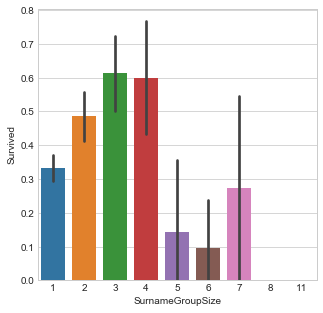

In [68]:
sns.barplot(x='SurnameGroupSize', y='Survived', data = all_data)

In [69]:
ticket_group_value_count = dict(all_data.TicketGroupId.value_counts())
all_data['TicketGroupSize'] = all_data.apply(lambda row : ticket_group_value_count[row.TicketGroupId], axis=1)

all_data.sort_values(['TicketGroupId']).loc[:, ['TicketGroupSize', 'TicketGroupId', 'SurnameGroupId', 'Cabin', 'Name', 'SibSp', 'Parch', 'Age']].head(6)

,TicketGroupSize,TicketGroupId,SurnameGroupId,Cabin,Name,SibSp,Parch,Age
1130,3,1-C-106.425-PC 17761,Douglas-1-C-106.425-PC 177__,C86,"Douglas, Mrs. Walter Donald (Mahala Dutton)",1,0,48.0
537,3,1-C-106.425-PC 17761,LeRoy-1-C-106.425-PC 177__,NaN,"LeRoy, Miss. Bertha",0,0,30.0
544,3,1-C-106.425-PC 17761,Douglas-1-C-106.425-PC 177__,C86,"Douglas, Mr. Walter Donald",1,0,50.0
1305,3,1-C-108.9-PC 17758,Oliva y Ocana-1-C-108.9-PC 177__,C105,"Oliva y Ocana, Dona. Fermina",0,0,39.0
307,3,1-C-108.9-PC 17758,Penasco y Castellana-1-C-108.9-PC 177__,C65,"Penasco y Castellana, Mrs. Victor de Satode (M...",1,0,17.0
505,3,1-C-108.9-PC 17758,Penasco y Castellana-1-C-108.9-PC 177__,C65,"Penasco y Castellana, Mr. Victor de Satode",1,0,18.0


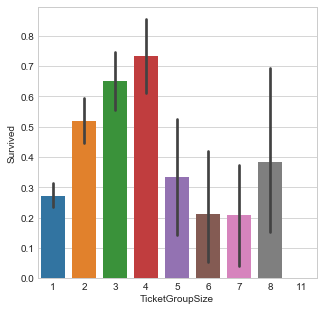

In [70]:
sns.barplot(x='TicketGroupSize', y='Survived', data = all_data)

In [71]:
test = all_data.iloc[train.shape[0]:, :]
train = all_data.iloc[:train.shape[0], :]
train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket,TicketSize,SingleTicketFare,Title,Surname,FamilySize,SurnameGroupId,TicketGroupId,SurnameGroupSize,TicketGroupSize
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,A/5 21171,1,7.25000,Mr,Braund,2,Braund-3-S-7.25-A/5 211__,3-S-7.25-A/5 21171,1,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,PC 17599,2,35.64165,Mrs,Cumings,2,Cumings-1-C-71.2833-PC 175__,1-C-71.2833-PC 17599,2,2
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,STON/O2. 3101282,1,7.92500,Miss,Heikkinen,1,Heikkinen-3-S-7.925-STON/O2. 31012__,3-S-7.925-STON/O2. 3101282,1,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,113803,2,26.55000,Mrs,Futrelle,2,Futrelle-1-S-53.1-1138__,1-S-53.1-113803,2,2
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,373450,1,8.05000,Mr,Allen,2,Allen-3-S-8.05-3734__,3-S-8.05-373450,1,1


#### 寻找保姆、远亲、朋友

In [72]:
tmp = pd.concat([train, test])
nannies_firends_cousins = addNanniesCousinsFriends(all_data, verbose=True)

Tottaly 789 solo passengers satifies the condtions
Totally adding 130  nannies, cousins and firends to surname groups


In [73]:
nannies_firends_cousins_data = tmp.loc[tmp.SurnameGroupId.isin(nannies_firends_cousins), ['SurnameGroupId', 'TicketGroupId', 'Pclass', 'Embarked', 'Sex', 'Fare', 'Ticket', 'SibSp', 'Parch', 'Age', 'Surname','Survived']].sort_values(['TicketGroupId'])

len(nannies_firends_cousins_data.TicketGroupId.unique())

65

In [74]:
tmp = None
nannies_firends_cousins_data.drop(['Pclass','Embarked', 'Fare'], axis = 1).head(20)

,SurnameGroupId,TicketGroupId,Sex,Ticket,SibSp,Parch,Age,Surname,Survived
544,Douglas-1-C-106.425-PC 177__,1-C-106.425-PC 17761,male,PC 17761,1,0,50.0,Douglas,0.0
537,LeRoy-1-C-106.425-PC 177__,1-C-106.425-PC 17761,female,PC 17761,0,0,30.0,LeRoy,1.0
1130,Douglas-1-C-106.425-PC 177__,1-C-106.425-PC 17761,female,PC 17761,1,0,48.0,Douglas,NaN
1305,Oliva y Ocana-1-C-108.9-PC 177__,1-C-108.9-PC 17758,female,PC 17758,0,0,39.0,Oliva y Ocana,NaN
505,Penasco y Castellana-1-C-108.9-PC 177__,1-C-108.9-PC 17758,male,PC 17758,1,0,18.0,Penasco y Castellana,0.0
307,Penasco y Castellana-1-C-108.9-PC 177__,1-C-108.9-PC 17758,female,PC 17758,1,0,17.0,Penasco y Castellana,1.0
698,Thayer-1-C-110.8833-174__,1-C-110.8833-17421,male,17421,1,1,49.0,Thayer,0.0
581,Thayer-1-C-110.8833-174__,1-C-110.8833-17421,female,17421,1,1,39.0,Thayer,1.0
550,Thayer-1-C-110.8833-174__,1-C-110.8833-17421,male,17421,0,2,17.0,Thayer,1.0
306,Fleming-1-C-110.8833-174__,1-C-110.8833-17421,female,17421,0,0,NaN,Fleming,1.0


**我们来看看之前的保姆、远亲、朋友组**：

In [75]:
nannies_firends_cousins_data.loc[(nannies_firends_cousins_data.Ticket == 'PC 17608') | (nannies_firends_cousins_data.Ticket == '113572') | (nannies_firends_cousins_data.Ticket == '1601')]

,SurnameGroupId,TicketGroupId,Pclass,Embarked,Sex,Fare,Ticket,SibSp,Parch,Age,Surname,Survived
915,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,female,262.3750,PC 17608,1,3,48.0,Ryerson,NaN
1033,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,male,262.3750,PC 17608,1,3,61.0,Ryerson,NaN
950,Chaudanson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,female,262.3750,PC 17608,0,0,36.0,Chaudanson,NaN
311,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,female,262.3750,PC 17608,2,2,18.0,Ryerson,1.0
742,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,female,262.3750,PC 17608,2,2,21.0,Ryerson,1.0
955,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,male,262.3750,PC 17608,2,2,13.0,Ryerson,NaN
1266,Bowen-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,female,262.3750,PC 17608,0,0,45.0,Bowen,NaN
61,Icard-1-nan-80.0-1135__,1-nan-80.0-113572,1,NaN,female,80.0000,113572,0,0,38.0,Icard,1.0
829,Stone-1-nan-80.0-1135__,1-nan-80.0-113572,1,NaN,female,80.0000,113572,0,0,62.0,Stone,1.0
838,Chip-3-S-56.4958-16__,3-S-56.4958-1601,3,S,male,56.4958,1601,0,0,32.0,Chip,1.0


In [76]:
nannies_firends_cousins_data.loc[nannies_firends_cousins_data.Surname.isin(['Spedden', 'Allison', 'Zabour', 'Panula', 'Wick', 'Ryerson'])]

,SurnameGroupId,TicketGroupId,Pclass,Embarked,Sex,Fare,Ticket,SibSp,Parch,Age,Surname,Survived
319,Spedden-1-C-134.5-169__,1-C-134.5-16966,1,C,female,134.5000,16966,1,1,40.00,Spedden,1.0
1087,Spedden-1-C-134.5-169__,1-C-134.5-16966,1,C,male,134.5000,16966,0,2,6.00,Spedden,NaN
1133,Spedden-1-C-134.5-169__,1-C-134.5-16966,1,C,male,134.5000,16966,1,1,45.00,Spedden,NaN
915,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,female,262.3750,PC 17608,1,3,48.00,Ryerson,NaN
1033,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,male,262.3750,PC 17608,1,3,61.00,Ryerson,NaN
311,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,female,262.3750,PC 17608,2,2,18.00,Ryerson,1.0
742,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,female,262.3750,PC 17608,2,2,21.00,Ryerson,1.0
955,Ryerson-1-C-262.375-PC 176__,1-C-262.375-PC 17608,1,C,male,262.3750,PC 17608,2,2,13.00,Ryerson,NaN
498,Allison-1-S-151.55-1137__,1-S-151.55-113781,1,S,female,151.5500,113781,1,2,25.00,Allison,0.0
297,Allison-1-S-151.55-1137__,1-S-151.55-113781,1,S,female,151.5500,113781,1,2,2.00,Allison,0.0


In [77]:
nannies_firends_cousins_data.groupby(['SurnameGroupId']).Survived.mean().value_counts()

1.000000    60
0.000000    46
0.500000     5
0.333333     1
0.666667     1
Name: Survived, dtype: int64

#### 多人一起出行的分组平均幸存率

**查看原来的数据，利用未调整 `SurnameGroupId` 前的 `SurnameGroupSize` 的值：**

1.<font color='blue'>性别、年龄无差别统计一起出行的人平均幸存率：</font>

In [78]:
tmp = all_data.loc[(all_data.SurnameGroupSize > 1)].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

0.000000    73
1.000000    70
0.500000    29
0.666667     9
0.333333     1
0.750000     1
Name: Survived, dtype: int64

整组人全部幸存或全部遇难:

In [79]:
(tmp.loc[0] + tmp.loc[1]) / (np.sum(tmp.values))

0.7814207650273224

整组人幸存率大于等于$2/3$ 或 $0$:

In [80]:
np.sum(tmp.loc[(tmp.index > 0.5) | (tmp.index == 0)].values) / (np.sum(tmp.values))

0.8360655737704918

2.<font color='blue'>只统计一起出行的人当中把女性小孩单独分组的平均幸存率：</font>

In [81]:
tmp = all_data.loc[(all_data.SurnameGroupSize > 1) & (index_boy | index_female)].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

1.000000    101
0.000000     31
0.333333      1
0.750000      1
Name: Survived, dtype: int64

In [82]:
(tmp.loc[0] + tmp.loc[1]) / (np.sum(tmp.values))

0.9850746268656716

女性男孩的数据按照 `SurnameGroupId` 分组以后，几乎所有的男孩和女性要么全遇难，要么全部幸存。

<font color='red'>**调整 `SurnameGroupId` 后的数据，`SurnameGroupSize` 需要重新计算**</font>：

1.性别、年龄无差别统计一起出行的人平均幸存率：

In [83]:
surname_group_value_count = dict(all_data.SurnameGroupId.value_counts())
all_data['SurnameGroupSize'] = all_data.apply(lambda row : surname_group_value_count[row.SurnameGroupId], axis=1)

In [84]:
tmp = all_data.loc[(all_data.SurnameGroupSize > 1)].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

0.000000    89
1.000000    84
0.500000    34
0.666667    11
0.750000     2
0.800000     1
0.333333     1
Name: Survived, dtype: int64

整组幸存率为$0$或$1$的概率：

In [85]:
(tmp.loc[0] + tmp.loc[1]) / (np.sum(tmp.values))

0.7792792792792793

整组幸存率大于等于$2/3$或$0$ :

In [86]:
np.sum(tmp.loc[(tmp.index > 0.5) | (tmp.index == 0)].values) / (np.sum(tmp.values))

0.8423423423423423

2.只统计一起出行的人当中把**女性男孩单独分组**的平均幸存率：

In [87]:
tmp = all_data.loc[(all_data.SurnameGroupSize > 1) & (index_boy | index_female)].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

1.00    122
0.00     34
0.75      1
0.50      1
Name: Survived, dtype: int64

整组幸存率为0或1的概率：

In [88]:
(tmp.loc[0] + tmp.loc[1]) / np.sum(tmp.values)

0.9873417721518988

回顾一下之前的<font color='red'>**目标**</font>：<font color='blue'><strong>默认预测女性都存活，男性都遇难，再加上以下：</strong></font>

1. <font color='blue'>预测什么样的女性会遇难，毕竟少数，如果能够预测对，正确率就会极大提高。</font>

2. <font color='blue'>预测什么样的男孩（最小年龄段的男性）会幸存，也是少数，如果能够预测对，正确率就会极大提高。</font>

3. <font color='blue'>不是第一个年龄段的男性什么条件下会存活？</font>

##### 遇难的女性所在的分组情况：

In [89]:
perished_females_in_group = all_data.loc[(all_data.SurnameGroupSize > 1) & (all_data.Survived == 0) & (index_female), 'SurnameGroupId'].unique()
perished_females_in_group

array(['Vander Planke-3-S-18.0-3457__', 'Palsson-3-S-21.075-3499__',
       'Turpin-2-S-21.0-116__', 'Arnold-Franchi-3-S-17.8-3492__',
       'Goodwin-3-S-46.9-CA 21__', 'Zabour-3-C-14.4542-26__',
       'Jussila-3-S-9.825-41__', 'Yousseff-3-C-14.4583-26__',
       'Andersson-3-S-31.275-3470__', 'Robins-3-S-14.5-A/5. 33__',
       'Boulos-3-C-15.2458-26__', 'Ford-3-S-34.375-W./C. 66__',
       'Skoog-3-S-27.9-3470__', 'Sage-3-S-69.55-CA. 23__',
       'Strom-3-S-10.4625-3470__', 'Lefebre-3-S-25.4667-41__',
       'Rosblom-3-S-20.2125-3701__', 'Allison-1-S-151.55-1137__',
       'Lahtinen-2-S-26.0-2506__', 'Barbara-3-C-14.4542-26__',
       'Oreskovic-3-S-8.6625-3150__', 'Van Impe-3-S-24.15-3457__',
       'Danbom-3-S-14.4-3470__', 'Canavan-3-Q-7.75-3648__',
       'Cacic-3-S-8.6625-3150__', 'Caram-3-C-14.4583-26__',
       'Lobb-3-S-16.1-A/5. 33__', 'Panula-3-S-39.6875-31012__',
       'Bourke-3-Q-15.5-3648__', 'Ilmakangas-3-S-7.925-STON/O2. 31012__',
       'Mudd-2-S-10.5-S.O./P.P.__'

In [90]:
tmp = all_data.loc[all_data.SurnameGroupId.isin(perished_females_in_group), ['SurnameGroupId', 'Survived']].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

0.0    33
0.5     1
Name: Survived, dtype: int64

In [91]:
tmp[0] / tmp.values.sum()

0.9705882352941176

遇难的女性所在的分组不幸全军覆没，由此可以得出结论：如果整组都遇难那么，所在组的女性就会遇难。

##### 幸存的女性所在的分组情况：

In [92]:
survived_females_in_group = all_data.loc[(all_data.SurnameGroupSize > 1) & (all_data.Survived == 1.0) & (index_female), 'SurnameGroupId'].unique()
tmp = all_data.loc[all_data.SurnameGroupId.isin(survived_females_in_group), ['SurnameGroupId', 'Survived']].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

1.000000    75
0.500000    28
0.666667    10
0.750000     2
0.333333     1
Name: Survived, dtype: int64

In [93]:
tmp[1] / tmp.values.sum()

0.646551724137931

##### 遇难的男孩所在的分组情况

In [94]:
perished_boys_in_group = all_data.loc[ (all_data.SurnameGroupSize > 1) & (all_data.Survived == 0) & (index_boy), 'SurnameGroupId'].unique()
perished_boys_in_group

array(['Palsson-3-S-21.075-3499__', 'Rice-3-Q-29.125-3826__',
       'Panula-3-S-39.6875-31012__', 'Goodwin-3-S-46.9-CA 21__',
       'Skoog-3-S-27.9-3470__', 'Sage-3-S-69.55-CA. 23__',
       'Lefebre-3-S-25.4667-41__', 'Asplund-3-S-31.3875-3470__',
       'Hassan-3-C-18.7875-26__', 'Andersson-3-S-31.275-3470__'],
      dtype=object)

In [95]:
tmp = all_data.loc[all_data.SurnameGroupId.isin(perished_boys_in_group), ['SurnameGroupId', 'Survived']].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp 

0.00    8
0.50    1
0.75    1
Name: Survived, dtype: int64

In [96]:
tmp[0] / tmp.values.sum()

0.8

遇难的男孩所在的分组不幸全军覆没，由此可以得出结论：如果整组都遇难那么，所在组的男孩就会遇难。

##### 幸存男孩所在的分组

In [97]:
survived_boys_in_group = all_data.loc[ (all_data.SurnameGroupSize > 1) & (all_data.Survived == 1) & (index_boy), 'SurnameGroupId'].unique()
tmp = all_data.loc[all_data.SurnameGroupId.isin(survived_boys_in_group), ['SurnameGroupId', 'Survived']].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

1.000000    12
0.500000     4
0.666667     2
0.750000     1
Name: Survived, dtype: int64

In [98]:
tmp[1] / tmp.values.sum()

0.631578947368421

##### 幸存成年男性所在分组情况

由之前分析我们得到，成年男性幸存率非常低 $20\%$不到

In [99]:
survived_male_adults_in_group = all_data.loc[(all_data.SurnameGroupSize > 1) & (all_data.Survived == 1) & (~index_boy) & (all_data.Sex == 'male')]
survived_male_adults_in_group.SurnameGroupId.unique()

array(['Ling-3-S-56.4958-16__', 'Greenfield-1-C-63.3583-PC 177__',
       'Hassan-3-C-18.7875-26__', 'Hoyt-1-S-90.0-199__',
       'Beckwith-1-S-52.5542-117__', 'Tornquist-3-S-0.0-LI__',
       'McCoy-3-Q-23.25-3672__', 'Harder-1-C-55.4417-117__',
       'Carter-1-S-120.0-1137__', 'Goldenberg-1-C-89.1042-174__',
       'Bishop-1-C-91.0792-119__', 'Beane-2-S-26.0-29__',
       'Thayer-1-C-110.8833-174__', 'Jonsson-3-S-7.8542-3504__',
       'Frolicher-Stehli-1-C-79.2-135__',
       'Duff Gordon-1-C-56.9292-PC 174__', 'Kimball-1-S-52.5542-117__',
       'Nakid-3-C-15.7417-26__', 'Harper-1-C-76.7292-PC 175__',
       'Frauenthal-1-S-133.65-PC 176__', 'Cardeza-1-C-512.3292-PC 177__',
       'Dick-1-S-57.0-174__', 'Lam-3-S-56.4958-16__',
       'Taylor-1-S-52.0-199__', 'Chambers-1-S-53.1-1138__'], dtype=object)

In [100]:
survived_male_adults_in_group.shape

(30, 21)

In [101]:
tmp = all_data.loc[all_data.SurnameGroupId.isin(survived_male_adults_in_group.SurnameGroupId), ['SurnameGroupId', 'Survived']].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

1.00    20
0.50     3
0.80     1
0.75     1
Name: Survived, dtype: int64

In [102]:
tmp.loc[1] / tmp.values.sum()

0.8

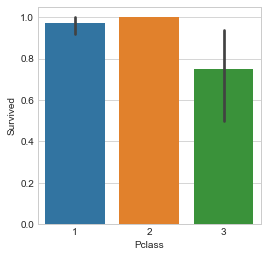

In [103]:
pylab.rcParams['figure.figsize'] = (4,4)
sns.barplot(x='Pclass', y='Survived', data=all_data.loc[all_data.SurnameGroupId.isin(survived_male_adults_in_group.SurnameGroupId)])

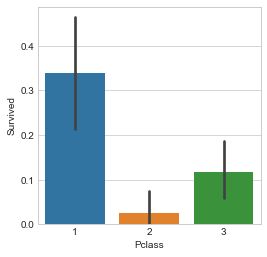

In [104]:
male_adults_in_group = all_data.loc[(all_data.SurnameGroupSize > 1) & (~index_boy) & (all_data.Sex == 'male')]
pylab.rcParams['figure.figsize'] = (4,4)
sns.barplot(x='Pclass', y='Survived', data=male_adults_in_group)

In [105]:
#all_data.loc[all_data.SurnameGroupId.isin(survived_male_adults_in_group.SurnameGroupId)].sort_values(['SurnameGroupId']).to_csv('幸存的成年男性.csv', index = None)

##### 遇难成年男性所在分组情况

In [106]:
perished_male_adults_in_group = all_data.loc[(all_data.SurnameGroupSize > 1) & (all_data.Survived == 0) & (~index_boy) & (all_data.Sex == 'male'), 'SurnameGroupId'].unique()
tmp = all_data.loc[all_data.SurnameGroupId.isin(perished_male_adults_in_group), ['SurnameGroupId', 'Survived']].groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

0.000000    76
0.500000    32
0.666667    11
0.800000     1
0.333333     1
0.750000     1
Name: Survived, dtype: int64

In [107]:
tmp.loc[0] / tmp.values.sum()

0.6229508196721312

In [108]:
perished_females_in_group = None
survived_females_in_group = None
perished_boys_in_group = None
survived_male_adults_in_group = None
perished_male_adults_in_group = None

<font color='red'>**经过上面的分析，我们能用到的就是将女士和男孩单独区分出来，当他们所在的组是全部幸存或者全部遇难的话，就可以直接判断他们幸存与否**</font>

### 整组幸存情况都未知

回顾一下之前的<font color='red'>**目标**</font>：<font color='blue'><strong>默认预测女性都存活，男性都遇难，再加上以下：</strong></font>

1. <font color='blue'>预测什么样的女性会遇难，毕竟少数，如果能够预测对，正确率就会极大提高。</font>

2. <font color='blue'>预测什么样的男孩（最小年龄段的男性）会幸存，也是少数，如果能够预测对，正确率就会极大提高。</font>

3. <font color='blue'>不是第一个年龄段的男性什么条件下会存活？</font>

我们这时候需要考虑**整组人是否幸存都未知的数据**，因为这样的数据我们没法利用组内的平均幸存率做预测。

In [109]:
selected_features = ['SurnameGroupId', 'Cabin', 'Pclass', 'Embarked', 'Sex', 'Fare', 'TicketGroupId', 'SibSp', 'Parch', 'Age', 'Survived', 'Title', 'SurnameGroupSize', 'SingleTicketFare']
groups = all_data.loc[(all_data.SurnameGroupSize > 1), selected_features].sort_values(['SurnameGroupId', 'Survived']).groupby(['SurnameGroupId'])

all_perished_groups = pd.DataFrame()
one_more_survived_groups = pd.DataFrame()

for index, group in groups:
    indices = group.Survived.value_counts().index
    if indices.shape[0] == 0:
        all_perished_groups = all_perished_groups.append(group)
    else:
        one_more_survived_groups = one_more_survived_groups.append(group)
        
groups = None

整组人幸存情况未知的组数为：

In [110]:
all_perished_groups.SurnameGroupId.unique().shape[0], len(one_more_survived_groups.SurnameGroupId.unique())

(21, 222)

In [111]:
all_perished_groups.SurnameGroupId.shape[0], one_more_survived_groups.SurnameGroupId.count()

(44, 606)

In [112]:
all_perished_groups.drop(['Survived', 'SurnameGroupSize'], axis=1)

,SurnameGroupId,Cabin,Pclass,Embarked,Sex,Fare,TicketGroupId,SibSp,Parch,Age,Title,SingleTicketFare
948,Abelseth-3-S-7.65-3481__,F G63,3,S,male,7.6500,3-S-7.65-348122,0,0,25.00,Mr,7.650000
1236,Abelseth-3-S-7.65-3481__,NaN,3,S,female,7.6500,3-S-7.65-348125,0,0,16.00,Miss,7.650000
1105,Andersson-3-S-7.775-3470__,NaN,3,S,female,7.7750,3-S-7.775-347091,4,2,38.00,Miss,7.775000
1211,Andersson-3-S-7.775-3470__,NaN,3,S,male,7.7750,3-S-7.775-347075,0,0,26.00,Mr,7.775000
1143,Clark-1-C-136.7792-135__,C89,1,C,male,136.7792,1-C-136.7792-13508,1,0,27.00,Mr,68.389600
1163,Clark-1-C-136.7792-135__,C89,1,C,female,136.7792,1-C-136.7792-13508,1,0,26.00,Mrs,68.389600
981,Dyker-3-S-13.9-3470__,NaN,3,S,female,13.9000,3-S-13.9-347072,1,0,22.00,Mrs,6.950000
1063,Dyker-3-S-13.9-3470__,NaN,3,S,male,13.9000,3-S-13.9-347072,1,0,23.00,Mr,6.950000
1259,Gibson-1-C-59.4-1123__,NaN,1,C,female,59.4000,1-C-59.4-112378,0,1,45.00,Mrs,29.700000
1293,Gibson-1-C-59.4-1123__,NaN,1,C,female,59.4000,1-C-59.4-112378,0,1,22.00,Miss,29.700000


挑出女性和男孩的情况： 

In [113]:
all_perished_groups.loc[(all_perished_groups.Sex == 'female') | ((all_perished_groups.Age <= children_age_upper_limit) & (all_perished_groups.Sex == 'male')) | (all_perished_groups.Title == 'Master')]

,SurnameGroupId,Cabin,Pclass,Embarked,Sex,Fare,TicketGroupId,SibSp,Parch,Age,Survived,Title,SurnameGroupSize,SingleTicketFare
1236,Abelseth-3-S-7.65-3481__,NaN,3,S,female,7.6500,3-S-7.65-348125,0,0,16.00,NaN,Miss,2,7.650000
1105,Andersson-3-S-7.775-3470__,NaN,3,S,female,7.7750,3-S-7.775-347091,4,2,38.00,NaN,Miss,2,7.775000
1163,Clark-1-C-136.7792-135__,C89,1,C,female,136.7792,1-C-136.7792-13508,1,0,26.00,NaN,Mrs,2,68.389600
981,Dyker-3-S-13.9-3470__,NaN,3,S,female,13.9000,3-S-13.9-347072,1,0,22.00,NaN,Mrs,2,6.950000
1259,Gibson-1-C-59.4-1123__,NaN,1,C,female,59.4000,1-C-59.4-112378,0,1,45.00,NaN,Mrs,2,29.700000
1293,Gibson-1-C-59.4-1123__,NaN,1,C,female,59.4000,1-C-59.4-112378,0,1,22.00,NaN,Miss,2,29.700000
1104,Howard-2-S-26.0-240__,NaN,2,S,female,26.0000,2-S-26.0-24065,1,0,60.00,NaN,Mrs,2,13.000000
956,Karnes-2-S-21.0-F.C.C. 135__,NaN,2,S,female,21.0000,2-S-21.0-F.C.C. 13534,0,0,NaN,NaN,Mrs,2,10.500000
1137,Karnes-2-S-21.0-F.C.C. 135__,NaN,2,S,female,21.0000,2-S-21.0-F.C.C. 13534,0,0,22.00,NaN,Mrs,2,10.500000
1140,Khalil-3-C-14.4542-26__,NaN,3,C,female,14.4542,3-C-14.4542-2660,1,0,NaN,NaN,Mrs,2,7.227100


检查一下：`van Billiard` 家庭：

In [114]:
all_data.loc[all_data.Surname == 'van Billiard'].drop(['Ticket', 'FamilySize', 'Surname', 'Name', 'TicketGroupSize', 'PassengerId'], axis = 1)

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,TicketSize,SingleTicketFare,Title,SurnameGroupId,TicketGroupId,SurnameGroupSize
153,40.5,NaN,S,14.5,2,3,male,0,0.0,3,4.833333,Mr,van Billiard-3-S-14.5-A/5. 8__,3-S-14.5-A/5. 851,3
1083,11.5,NaN,S,14.5,1,3,male,1,NaN,3,4.833333,Master,van Billiard-3-S-14.5-A/5. 8__,3-S-14.5-A/5. 851,3
1235,NaN,NaN,S,14.5,1,3,male,1,NaN,3,4.833333,Master,van Billiard-3-S-14.5-A/5. 8__,3-S-14.5-A/5. 851,3


#### 至少一个人生存情况可知的组

In [115]:
one_more_survived_groups.head(10)

,SurnameGroupId,Cabin,Pclass,Embarked,Sex,Fare,TicketGroupId,SibSp,Parch,Age,Survived,Title,SurnameGroupSize,SingleTicketFare
746,Abbott-3-S-20.25-C.A. 26__,NaN,3,S,male,20.2500,3-S-20.25-C.A. 2673,1,1,16.00,0.0,Mr,3,6.750000
279,Abbott-3-S-20.25-C.A. 26__,NaN,3,S,female,20.2500,3-S-20.25-C.A. 2673,1,1,35.00,1.0,Mrs,3,6.750000
1283,Abbott-3-S-20.25-C.A. 26__,NaN,3,S,male,20.2500,3-S-20.25-C.A. 2673,0,2,13.00,NaN,Master,3,6.750000
308,Abelson-2-C-24.0-P/PP 33__,NaN,2,C,male,24.0000,2-C-24.0-P/PP 3381,1,0,30.00,0.0,Mr,2,12.000000
874,Abelson-2-C-24.0-P/PP 33__,NaN,2,C,female,24.0000,2-C-24.0-P/PP 3381,1,0,28.00,1.0,Mrs,2,12.000000
855,Aks-3-S-9.35-3920__,NaN,3,S,female,9.3500,3-S-9.35-392091,0,1,18.00,1.0,Mrs,2,4.675000
1198,Aks-3-S-9.35-3920__,NaN,3,S,male,9.3500,3-S-9.35-392091,0,1,0.83,NaN,Master,2,4.675000
210,Ali-3-S-7.05-SOTON/O.Q. 31013__,NaN,3,S,male,7.0500,3-S-7.05-SOTON/O.Q. 3101311,0,0,24.00,0.0,Mr,2,7.050000
784,Ali-3-S-7.05-SOTON/O.Q. 31013__,NaN,3,S,male,7.0500,3-S-7.05-SOTON/O.Q. 3101312,0,0,25.00,0.0,Mr,2,7.050000
689,Allen-1-S-211.3375-241__,B5,1,S,female,211.3375,1-S-211.3375-24160,0,1,15.00,1.0,Miss,4,52.834375


#### Pclass

{1: 0.723404255319149, 2: 0.5567010309278351, 3: 0.27860696517412936}


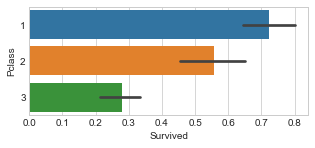

In [116]:
pclass_survived = dict(one_more_survived_groups.groupby(['Pclass']).Survived.mean())
print(pclass_survived)
plt.rcParams['figure.figsize'] =(5, 2)
sns.barplot(x='Survived', y='Pclass', data=one_more_survived_groups, orient='h')

#### Embarked

{'C': 0.6826923076923077, 'Q': 0.3181818181818182, 'S': 0.42443729903536975}


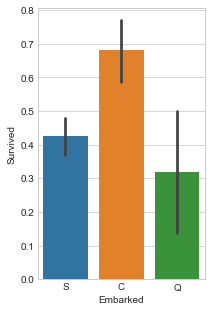

In [117]:
embarked_survived = dict(one_more_survived_groups.groupby(['Embarked']).Survived.mean())
print(embarked_survived)
plt.rcParams['figure.figsize'] =(3, 5)
sns.barplot(x='Embarked', y='Survived', data=one_more_survived_groups)

#### Fare

                  Survived
CategoricalFare           
(-0.001, 11.133]  0.148936
(11.133, 15.5]    0.391304
(15.5, 20.25]     0.522727
(20.25, 25.467]   0.380952
(25.467, 27.9]    0.468085
(27.9, 39.688]    0.363636
(39.688, 57.0]    0.577778
(57.0, 78.85]     0.523810
(78.85, 134.5]    0.795918
(134.5, 512.329]  0.696970


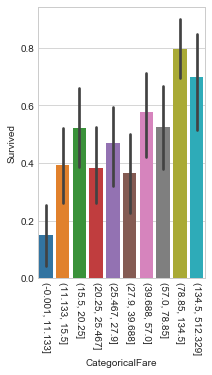

In [118]:
one_more_survived_groups['CategoricalFare'] = pd.qcut(one_more_survived_groups['Fare'], 10)
fare_survived = one_more_survived_groups.loc[:, ['CategoricalFare', 'Survived']].groupby(['CategoricalFare']).mean()
print(fare_survived)
plt.xticks(rotation=270)
plt.rcParams['figure.figsize'] =(5, 5)
sns.barplot(x='CategoricalFare', y='Survived', data=one_more_survived_groups)
#one_more_survived_groups.drop(['CategoricalFare'], axis = 1, inplace=True)

                   Survived
CategoricalFare            
(-0.001, 4.65]     0.242424
(4.65, 5.231]      0.346154
(5.231, 6.238]     0.448276
(6.238, 6.938]     0.321429
(6.938, 7.25]      0.266667
(7.25, 7.775]      0.428571
(7.775, 8.05]      0.212121
(8.05, 9.188]      0.384615
(9.188, 11.0]      0.500000
(11.0, 13.0]       0.527778
(13.0, 23.539]     0.538462
(23.539, 26.55]    0.647059
(26.55, 28.99]     0.916667
(28.99, 37.482]    0.653846
(37.482, 43.833]   0.615385
(43.833, 128.082]  0.846154


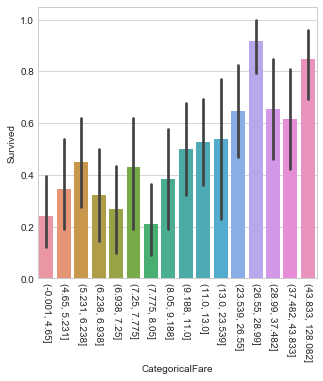

In [119]:
one_more_survived_groups['CategoricalFare'] = pd.qcut(one_more_survived_groups['SingleTicketFare'], 16)
fare_survived = one_more_survived_groups.loc[:, ['CategoricalFare', 'Survived']].groupby(['CategoricalFare']).mean()
print(fare_survived)
plt.xticks(rotation=270)
plt.rcParams['figure.figsize'] =(5, 5)
sns.barplot(x='CategoricalFare', y='Survived', data=one_more_survived_groups)
#one_more_survived_groups.drop(['CategoricalFare'], axis = 1, inplace=True)

#### Cabin

             Survived
OneBitCabin          
A            0.666667
B            0.815789
C            0.619048
D            0.818182
E            0.736842
F            0.833333
G            0.500000
U            0.373770


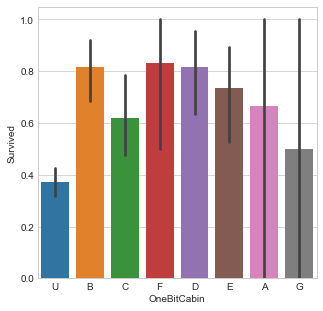

In [120]:
one_more_survived_groups.Cabin.fillna('Unknown', inplace=True)
one_more_survived_groups['OneBitCabin'] = one_more_survived_groups.Cabin.apply(lambda x: str(x)[0])
cabin_survived = one_more_survived_groups.loc[:, ['OneBitCabin', 'Survived']].groupby(['OneBitCabin']).mean()
print(cabin_survived)
sns.barplot(x='OneBitCabin', y='Survived', data=one_more_survived_groups)
#one_more_survived_groups.drop(['OneBitCabin'], axis = 1, inplace=True)

#### Sex

{'female': 0.7361111111111112, 'male': 0.23766816143497757}


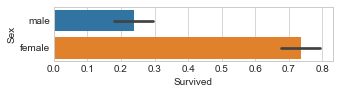

In [121]:
sex_survived = dict(one_more_survived_groups.groupby(['Sex']).Survived.mean())
print(sex_survived)
plt.rcParams['figure.figsize'] =(5, 1)
sns.barplot(x='Survived', y='Sex', data=one_more_survived_groups, orient='h')

#### Age

0.13861386138613863


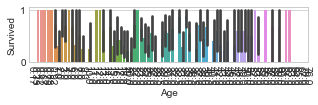

In [122]:
print(np.sum(one_more_survived_groups.Age.isna()) / one_more_survived_groups.shape[0])
plt.xticks(rotation=270)
pylab.rcParams['figure.figsize'] =(24, 8)
sns.barplot(x='Age', y='Survived', data=one_more_survived_groups)

In [123]:
def getAgeSegment(age):
    age_seg = 3 # 退休
    if age <= 15:
        age_seg = 1 # 小孩
    elif age <= 60:  
        age_seg = 2 # 未退休

    return np.int32(age_seg)

{1: 0.5822784810126582, 2: 0.48109965635738833, 3: 0.37681159420289856}


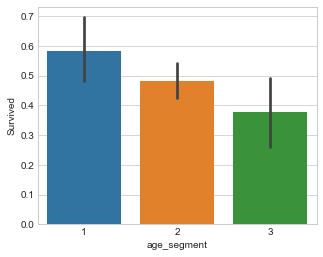

In [124]:
one_more_survived_groups['age_segment'] = one_more_survived_groups.Age.apply(lambda x: getAgeSegment(x))
age_survived = dict(one_more_survived_groups.groupby(['age_segment']).Survived.mean())
print(age_survived)
plt.rcParams['figure.figsize'] = (5, 4)
sns.barplot(x='age_segment', y='Survived', data=one_more_survived_groups)

age_segment  Sex   
1            female    0.641026
             male      0.525000
2            female    0.773973
             male      0.186207
3            female    0.677419
             male      0.131579
Name: Survived, dtype: float64


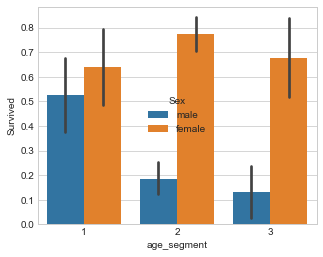

In [125]:
from numpy import mean
sex_age_survived = one_more_survived_groups.groupby(['age_segment', 'Sex']).Survived.mean()
print(sex_age_survived)
sns.barplot(x='age_segment', y='Survived', hue='Sex', data=one_more_survived_groups, estimator=mean)

In [126]:
one_more_survived_groups.columns

Index(['SurnameGroupId', 'Cabin', 'Pclass', 'Embarked', 'Sex', 'Fare',
       'TicketGroupId', 'SibSp', 'Parch', 'Age', 'Survived', 'Title',
       'SurnameGroupSize', 'SingleTicketFare', 'CategoricalFare',
       'OneBitCabin', 'age_segment'],
      dtype='object')

In [127]:
all_perished_groups.columns

Index(['SurnameGroupId', 'Cabin', 'Pclass', 'Embarked', 'Sex', 'Fare',
       'TicketGroupId', 'SibSp', 'Parch', 'Age', 'Survived', 'Title',
       'SurnameGroupSize', 'SingleTicketFare'],
      dtype='object')

#### women-children-group

In [128]:
indices_boy_groups = ((one_more_survived_groups.Age <= children_age_upper_limit) & (one_more_survived_groups.Sex == 'male')) | (one_more_survived_groups.Title == 'Master')
indices_female_groups = (one_more_survived_groups.Sex == 'female')

more_one_survived_wcg = one_more_survived_groups.loc[indices_boy_groups|indices_female_groups]
more_one_survived_wcg.shape[0]

358

In [129]:
indices_female_groups = None
indices_boy_groups = None

In [130]:
more_one_survived_wcg.head()

,SurnameGroupId,Cabin,Pclass,Embarked,Sex,Fare,TicketGroupId,SibSp,Parch,Age,Survived,Title,SurnameGroupSize,SingleTicketFare,CategoricalFare,OneBitCabin,age_segment
279,Abbott-3-S-20.25-C.A. 26__,Unknown,3,S,female,20.25,3-S-20.25-C.A. 2673,1,1,35.00,1.0,Mrs,3,6.750,"(6.238, 6.938]",U,2
1283,Abbott-3-S-20.25-C.A. 26__,Unknown,3,S,male,20.25,3-S-20.25-C.A. 2673,0,2,13.00,NaN,Master,3,6.750,"(6.238, 6.938]",U,1
874,Abelson-2-C-24.0-P/PP 33__,Unknown,2,C,female,24.00,2-C-24.0-P/PP 3381,1,0,28.00,1.0,Mrs,2,12.000,"(11.0, 13.0]",U,2
855,Aks-3-S-9.35-3920__,Unknown,3,S,female,9.35,3-S-9.35-392091,0,1,18.00,1.0,Mrs,2,4.675,"(4.65, 5.231]",U,2
1198,Aks-3-S-9.35-3920__,Unknown,3,S,male,9.35,3-S-9.35-392091,0,1,0.83,NaN,Master,2,4.675,"(4.65, 5.231]",U,1


In [131]:
tmp = more_one_survived_wcg.groupby(['SurnameGroupId']).Survived.mean().value_counts()
tmp

1.00    122
0.00     34
0.75      1
0.50      1
Name: Survived, dtype: int64

In [132]:
(tmp[1] + tmp[0]) / tmp.values.sum()

0.9873417721518988

##### Pclass

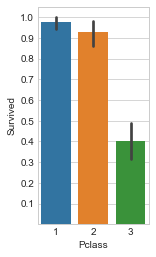

In [133]:
pylab.rcParams['figure.figsize'] = (2.0, 4.0) 
plt.yticks(np.linspace(0.1, 1.0, 10))
sns.barplot(x='Pclass', y='Survived', data=more_one_survived_wcg)

##### Embarked

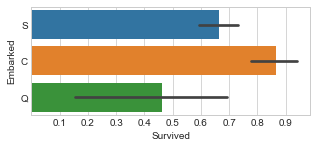

In [134]:
pylab.rcParams['figure.figsize'] = (5.0, 2.0) 
plt.xticks(ticks=np.linspace(0.1, 1.0, 10))
sns.barplot(x='Survived', y='Embarked', data=more_one_survived_wcg, orient='h')

##### Cabin

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


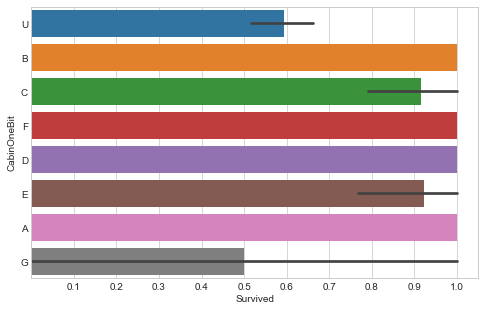

In [135]:
more_one_survived_wcg['Cabin'] = more_one_survived_wcg.Cabin.fillna("Unknown")
more_one_survived_wcg['CabinOneBit'] = more_one_survived_wcg.Cabin.apply(lambda x: str(x)[0])
pylab.rcParams['figure.figsize'] = (8.0, 5.0) 
plt.xticks(ticks=np.linspace(0.1, 1.0, 10))
sns.barplot(x='Survived', y='CabinOneBit', data=more_one_survived_wcg, orient='h')

##### Fare

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


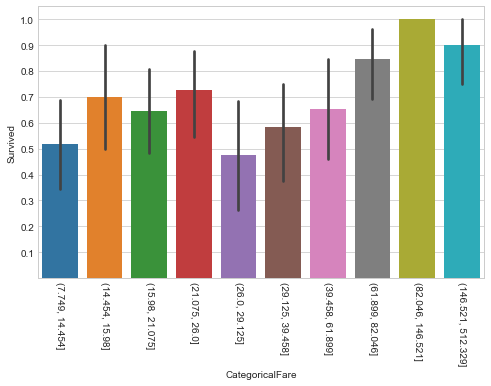

In [136]:
more_one_survived_wcg['CategoricalFare'] = pd.qcut(more_one_survived_wcg['Fare'], 10)
fare_survived = more_one_survived_wcg.loc[:,['CategoricalFare', 'Survived']].groupby(['CategoricalFare']).mean()
plt.xticks(rotation=270)
plt.yticks(ticks=np.linspace(0.1, 1.0, 10))
pylab.rcParams['figure.figsize'] =(10, 5)
sns.barplot(x='CategoricalFare', y='Survived', data=more_one_survived_wcg, )
#one_more_survived_groups.drop(['CategoricalFare'], axis = 1, inplace=True)

In [137]:
print(fare_survived)

                    Survived
CategoricalFare             
(7.749, 14.454]     0.517241
(14.454, 15.98]     0.700000
(15.98, 21.075]     0.645161
(21.075, 26.0]      0.727273
(26.0, 29.125]      0.473684
(29.125, 39.458]    0.583333
(39.458, 61.899]    0.653846
(61.899, 82.046]    0.846154
(82.046, 146.521]   1.000000
(146.521, 512.329]  0.900000


##### Age

In [138]:
more_one_survived_wcg.Age.isna().sum() / more_one_survived_wcg.shape[0]

0.12569832402234637

In [139]:
def getAgeSegment(age):
    age_seg = 5 # 
    if age <= 12: # children
        age_seg = 1 
    elif age <= 18: # adults
        age_seg = 2
    elif age <= 45:
        age_seg = 3
    elif age <= 60: # retirement
        age_seg = 4
    return np.int32(age_seg)

{1: 0.5797101449275363, 2: 0.7272727272727273, 3: 0.7767857142857143, 4: 0.8421052631578947, 5: 0.6571428571428571}


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


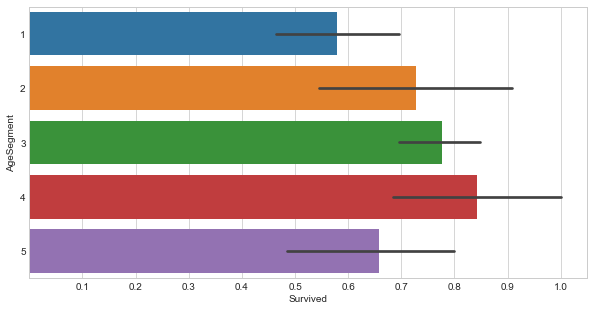

In [140]:
more_one_survived_wcg['AgeSegment'] = more_one_survived_wcg.Age.apply(lambda x: getAgeSegment(x))
age_survived = dict(more_one_survived_wcg.groupby(['AgeSegment']).Survived.mean())
print(age_survived)
plt.xticks(ticks=np.linspace(0.1, 1.0, 10))
plt.rcParams['figure.figsize'] = (6, 3)
sns.barplot(x='Survived', y='AgeSegment', data=more_one_survived_wcg, orient='h')

#### 整组幸存情况未知的预测策略

In [141]:
one_more_survived_groups[one_more_survived_groups.SurnameGroupId.notna()].shape[0]

606

### 单独出行

单独出行即 `SurnameGroupSize==1` 的乘客：

In [142]:
solo_passengers = all_data.loc[all_data.SurnameGroupSize == 1].drop(['Ticket', 'Title', 'Surname', 'SurnameGroupSize', 'TicketGroupSize', 'FamilySize'], axis=1)

print('the number of solo passengers: %d' % solo_passengers.shape[0])

the number of solo passengers: 659


#### Sex

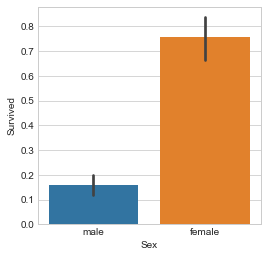

In [143]:
plt.rcParams['figure.figsize'] =(4, 4)
sns.barplot(x='Sex', y='Survived', data=solo_passengers)

#### Age

{1: nan, 2: 0.41935483870967744, 3: 0.2964426877470356, 4: 0.2894736842105263, 5: 0.23846153846153847}


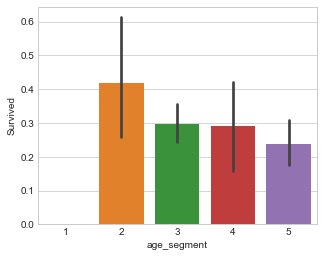

In [144]:
solo_passengers['age_segment'] = solo_passengers.Age.apply(lambda x: getAgeSegment(x))
age_survived = dict(solo_passengers.groupby(['age_segment']).Survived.mean())
print(age_survived)
plt.rcParams['figure.figsize'] =(5, 4)
sns.barplot(x='age_segment', y='Survived', data=solo_passengers)

#### Sex and Age

age_segment  Sex   
1            male           NaN
2            female    0.785714
             male      0.117647
3            female    0.745098
             male      0.183168
4            female    0.875000
             male      0.133333
5            female    0.720000
             male      0.123810
Name: Survived, dtype: float64


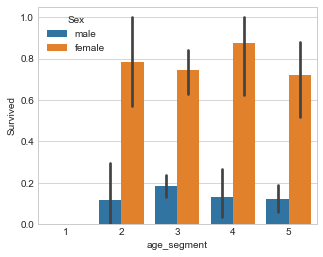

In [145]:
from numpy import mean
sex_age_survived = solo_passengers.groupby(['age_segment', 'Sex']).Survived.mean()
print(sex_age_survived)
sns.barplot(x='age_segment', y='Survived', hue='Sex', data=solo_passengers, estimator=mean)

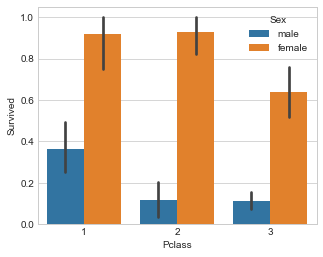

In [146]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=solo_passengers, estimator=mean)

                  Survived
CategoricalFare           
(-0.001, 7.25]    0.144928
(7.25, 7.75]      0.339623
(7.75, 7.879]     0.333333
(7.879, 8.05]     0.157895
(8.05, 9.5]       0.142857
(9.5, 13.0]       0.387500
(13.0, 26.55]     0.513514
(26.55, 135.633]  0.431818


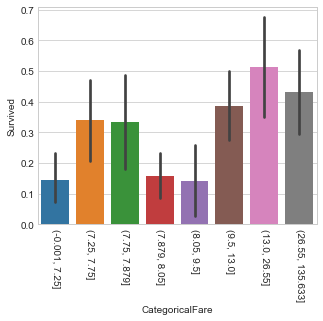

In [147]:
solo_passengers['CategoricalFare'] = pd.qcut(solo_passengers['Fare'], 8)
fare_survived = solo_passengers.loc[:, ['CategoricalFare', 'Survived']].groupby(['CategoricalFare']).mean()
print(fare_survived)
plt.xticks(rotation=270)
sns.barplot(x='CategoricalFare', y='Survived', data=solo_passengers)
solo_passengers.drop(['CategoricalFare'], axis = 1, inplace=True)

#### 单独出行的男孩

借此查看一下，所有`Master`的随行成员数量

In [148]:
tmp = all_data.loc[index_boy, 'SurnameGroupSize']
tmp.value_counts()

3     23
7      9
6      8
2      6
4      5
5      4
8      3
11     2
1      2
Name: SurnameGroupSize, dtype: int64

称谓是 `Master` 有1个是单独出行的

In [149]:
all_data.loc[(index_boy) & (all_data.SurnameGroupSize == 1)]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket,TicketSize,SingleTicketFare,Title,Surname,FamilySize,SurnameGroupId,TicketGroupId,SurnameGroupSize,TicketGroupSize
912,9.0,NaN,S,3.1708,"Olsen, Master. Artur Karl",1,913,3,male,0,...,C 17368,1,3.1708,Master,Olsen,4,Olsen-3-S-3.1708-C 173__,3-S-3.1708-C 17368,1,1
1230,NaN,NaN,C,7.2292,"Betros, Master. Seman",0,1231,3,male,0,...,2622,1,7.2292,Master,Betros,2,Betros-3-C-7.2292-26__,3-C-7.2292-2622,1,1


#### 单独出行的女性

In [150]:
tmp = train.loc[(train.Sex == 'female') & (train.SurnameGroupSize == 1), 'Survived'].value_counts()
tmp

1.0    74
0.0    24
Name: Survived, dtype: int64

In [151]:
tmp[0]/ tmp.values.sum()

0.24489795918367346

### 最后的特征

In [152]:
all_data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'TicketSize',
       'SingleTicketFare', 'Title', 'Surname', 'FamilySize', 'SurnameGroupId',
       'TicketGroupId', 'SurnameGroupSize', 'TicketGroupSize'],
      dtype='object')

### K折交叉验证

In [153]:
def custom_cv(dataset, num_fold = 5, verbose = False, num_trial = 5):
    sum_accuracy_all_trial = 0.0
    size_test_set_in_cv = dataset.shape[0] // num_fold    
    engineeringFeatures(dataset, verbose)
    
    for i in range(0, num_trial):
        sum_accuracy_per_trial = 0.0
        all_set_in_cv = dataset.sample(n = train.shape[0], random_state= i)
        for j in range(0, num_fold):
            
            # get indices of test set and train set in cross validation
            start_index_test_set = j * size_test_set_in_cv
            indices_test_set_in_cv = np.linspace(0, size_test_set_in_cv - 1, num = size_test_set_in_cv, dtype=np.int32) + start_index_test_set
            indices_train_set_in_cv = all_set_in_cv.drop(labels=indices_test_set_in_cv).index
            
            # get WomanChildGroupSurvived in train set 
            getWomanChildrenGroupSurvived(all_set_in_cv, indices_train_set_in_cv)
            # set WomanChildGroupSurvived in test set
            setWomenChildGroupSurvivedInTestSet(all_set_in_cv, indices_test_set_in_cv)
            
            # get SurnameGroupSurvived
            #getSurnameGroupSurvived(all_set_in_cv, indices_train_set_in_cv)
            #setSurnameGroupSurvivedInTestSet(all_set_in_cv, indices_test_set_in_cv)
            
            # female and boy rules
            all_set_in_cv = predictionByWomanBoyRules(all_set_in_cv)

            accuracy_per_time = np.sum(all_set_in_cv.iloc[indices_test_set_in_cv, :].Predict.astype(np.int32).values == all_set_in_cv.iloc[indices_test_set_in_cv, :].Survived.astype(np.int32).values) / size_test_set_in_cv
            sum_accuracy_per_trial += accuracy_per_time  
            # the end of for j in range(0, num_fold)
            
        sum_accuracy_per_trial = sum_accuracy_per_trial / num_fold
        sum_accuracy_all_trial += sum_accuracy_per_trial
        if verbose == True:
            print("Trial %d has %d-fold CV accuracy = %f" % (i + 1, num_fold, sum_accuracy_per_trial)) 
        # the end of for i in range(0, num_trial)
        
    print('Average accuracy in trials of total %d times  = %f' % (num_trial, sum_accuracy_all_trial / num_trial)) 

In [154]:
custom_cv(num_fold = 10, verbose = True, num_trial = 10, dataset = pd.read_csv('./data/train.csv'))

Tottaly 179 solo passengers satifies the condtions
Totally adding 46  nannies, cousins and firends to surname groups
Trial 1 has 10-fold CV accuracy = 0.865169
Trial 2 has 10-fold CV accuracy = 0.866292
Trial 3 has 10-fold CV accuracy = 0.866292
Trial 4 has 10-fold CV accuracy = 0.860674
Trial 5 has 10-fold CV accuracy = 0.865169
Trial 6 has 10-fold CV accuracy = 0.864045
Trial 7 has 10-fold CV accuracy = 0.866292
Trial 8 has 10-fold CV accuracy = 0.865169
Trial 9 has 10-fold CV accuracy = 0.862921
Trial 10 has 10-fold CV accuracy = 0.864045
Average accuracy in trials of total 10 times  = 0.864607


### 预测

In [155]:
#getSurnameGroupSurvived(all_data, train.index)
#setSurnameGroupSurvivedInTestSet(all_data, test.index)

all_data['WomanChildGroupSurvived'] = np.NaN
getWomanChildrenGroupSurvived(all_data, train.index)
setWomenChildGroupSurvivedInTestSet(all_data, test.index)

In [156]:
all_data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'TicketSize',
       'SingleTicketFare', 'Title', 'Surname', 'FamilySize', 'SurnameGroupId',
       'TicketGroupId', 'SurnameGroupSize', 'TicketGroupSize',
       'SurnameGroupSurvived', 'WomanChildGroupSurvived', 'WomanChildGroupId'],
      dtype='object')

In [164]:
all_data = predictionByWomanBoyRules(all_data)
np.sum(all_data.Predict[:train.shape[0]] == all_data.Survived[:train.shape[0]]) / train.shape[0]

0.8720538720538721

In [165]:
PassengerId = np.array(range(892, 892 + test.shape[0]))
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": all_data.Predict[train.shape[0]:].astype(np.int32)})
submission.index=range(0, test.shape[0])
submission.to_csv('./data/' + "2.csv", index=False)

In [166]:
result_83772 = pd.read_csv('./data/' + "same.csv")
np.sum(result_83772.Survived != submission.Survived)

11

In [167]:
differential_indices = submission.loc[(submission.Survived != result_83772.Survived) & (submission.Survived.notna())].index

In [168]:
differential_passenger_id = submission.loc[differential_indices].PassengerId.values
differential_passenger_id

array([ 982, 1017, 1092, 1106, 1165, 1201, 1237, 1251, 1268, 1274, 1275])

In [169]:
differential_surname_group_id = all_data.loc[all_data.PassengerId.isin(differential_passenger_id), 'SurnameGroupId']

differential_surname_group_id

981          Dyker-3-S-13.9-3470__
1016         Cribb-3-S-16.1-3713__
1091         Murphy-3-Q-15.5-365__
1105    Andersson-3-S-7.775-3470__
1164        Lennon-3-Q-15.5-3703__
1200     Hansen-3-S-14.1083-3500__
1236      Abelseth-3-S-7.65-3481__
1250      Lindell-3-S-15.55-3499__
1267        Kink-3-S-8.6625-3151__
1273        Risien-3-S-14.5-3644__
1274       McNamee-3-S-16.1-3765__
Name: SurnameGroupId, dtype: object

In [170]:
selected_features = ['SurnameGroupId', 'SurnameGroupSurvived',  'Sex', 'Age', 'Survived', 'Predict', 'Pclass', 'WomanChildGroupId', 'WomanChildGroupSurvived']

all_data.loc[all_data.SurnameGroupId.isin(differential_surname_group_id),selected_features].sort_values(['SurnameGroupId'])

,SurnameGroupId,SurnameGroupSurvived,Sex,Age,Survived,Predict,Pclass,WomanChildGroupId,WomanChildGroupSurvived
1236,Abelseth-3-S-7.65-3481__,1.0,female,16.0,NaN,0.0,3,Abelseth-3-S-7.65-3481__,0.000000
948,Abelseth-3-S-7.65-3481__,1.0,male,25.0,NaN,0.0,3,NoGroup,0.252366
1211,Andersson-3-S-7.775-3470__,1.0,male,26.0,NaN,0.0,3,NoGroup,0.252366
1105,Andersson-3-S-7.775-3470__,1.0,female,38.0,NaN,0.0,3,Andersson-3-S-7.775-3470__,0.000000
1016,Cribb-3-S-16.1-3713__,0.0,female,17.0,NaN,0.0,3,Cribb-3-S-16.1-3713__,0.000000
160,Cribb-3-S-16.1-3713__,0.0,male,44.0,0.0,0.0,3,NoGroup,0.252366
981,Dyker-3-S-13.9-3470__,1.0,female,22.0,NaN,0.0,3,Dyker-3-S-13.9-3470__,0.000000
1063,Dyker-3-S-13.9-3470__,1.0,male,23.0,NaN,0.0,3,NoGroup,0.252366
1200,Hansen-3-S-14.1083-3500__,0.0,female,45.0,NaN,0.0,3,Hansen-3-S-14.1083-3500__,0.000000
860,Hansen-3-S-14.1083-3500__,0.0,male,41.0,0.0,0.0,3,NoGroup,0.252366


In [171]:
all_data.loc[all_data.SurnameGroupId == 'Abelseth-3-S-7.65-3481__']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Surname,FamilySize,SurnameGroupId,TicketGroupId,SurnameGroupSize,TicketGroupSize,SurnameGroupSurvived,WomanChildGroupSurvived,WomanChildGroupId,Predict
948,25.0,F G63,S,7.65,"Abelseth, Mr. Olaus Jorgensen",0,949,3,male,0,...,Abelseth,2,Abelseth-3-S-7.65-3481__,3-S-7.65-348122,2,1,1.0,0.252366,NoGroup,0.0
1236,16.0,NaN,S,7.65,"Abelseth, Miss. Karen Marie",0,1237,3,female,0,...,Abelseth,2,Abelseth-3-S-7.65-3481__,3-S-7.65-348125,2,1,1.0,0.000000,Abelseth-3-S-7.65-3481__,0.0


### Maiden Name

In [172]:
def getMaidenName(name):
    title_search = re.search('\(([A-Za-z]+) ([A-Za-z]+)\)', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(2)
    return ''

all_data['MaidenName'] = all_data.Name.apply(getMaidenName)

In [173]:
all_data.sort_values(['MaidenName']).loc[all_data['MaidenName'] != '',['Age', 'SurnameGroupId', 'MaidenName', 'SibSp', 'Parch', 'Sex', 'TicketGroupId']].head()

,Age,SurnameGroupId,MaidenName,SibSp,Parch,Sex,TicketGroupId
9,14.0,Nasser-2-C-30.0708-2377__,Achem,1,0,female,2-C-30.0708-237736
830,15.0,Yasbeck-3-C-14.4542-26__,Alexander,1,0,female,3-C-14.4542-2659
765,51.0,Longley-1-S-77.9583-135__,Andrews,1,0,female,1-S-77.9583-13502
1255,25.0,Harder-1-C-55.4417-117__,Annan,1,0,female,1-C-55.4417-11765
1137,22.0,Karnes-2-S-21.0-F.C.C. 135__,Bennett,0,0,female,2-S-21.0-F.C.C. 13534


In [174]:
all_data.loc[(all_data.Surname == 'Richards') | (all_data.Surname == 'Hocking') | (all_data.MaidenName == 'Needs'), ['PassengerId', 'Age', 'SurnameGroupId', 'Name', 'MaidenName', 'SibSp', 'Parch', 'Sex', 'Survived', 'Predict']].sort_values(['SurnameGroupId', 'Age'])

,PassengerId,Age,SurnameGroupId,Name,MaidenName,SibSp,Parch,Sex,Survived,Predict
529,530,23.00,Hocking-2-S-11.5-291__,"Hocking, Mr. Richard George",,2,1,male,0.0,0.0
1120,1121,36.00,Hocking-2-S-13.0-2429__,"Hocking, Mr. Samuel James Metcalfe",,0,0,male,NaN,0.0
943,944,20.00,Hocking-2-S-23.0-291__,"Hocking, Miss. Ellen Nellie""""",,2,1,female,NaN,1.0
774,775,54.00,Hocking-2-S-23.0-291__,"Hocking, Mrs. Elizabeth (Eliza Needs)",Needs,1,3,female,1.0,1.0
831,832,0.83,Richards-2-S-18.75-291__,"Richards, Master. George Sibley",,1,1,male,1.0,1.0
407,408,3.00,Richards-2-S-18.75-291__,"Richards, Master. William Rowe",,1,1,male,1.0,1.0
437,438,24.00,Richards-2-S-18.75-291__,"Richards, Mrs. Sidney (Emily Hocking)",Hocking,2,3,female,1.0,1.0
892,893,47.00,Wilkes-3-S-7.0-3632__,"Wilkes, Mrs. James (Ellen Needs)",Needs,1,0,female,NaN,1.0


除了第二行剩余的人都是一家人，**注意到：票价，舱室级别，票号都相差比较大**。

`age = 54` 是 grandmother，她有一个妹妹，她的孩子中
1. `PassengerId = 944` ， 未嫁的 `Age = 20` 的还在沿用家族姓氏
2. 已经出嫁的 `Age = 24` 的已经使用夫家的姓氏，但是圆括号里面也带了娘家姓氏 `MaidenName` , `PassengerId = 438`, 她有两个男孩：根据`SurnameGroupId`， `PassengerId = 832, 408`

3. 比较难以判断的是，到底第一行是不是Hocking家族的孩子。
![](./data/grandparents.png)

In [175]:
MaidenNameGroupSize_value_counts = all_data.MaidenName.value_counts()

In [176]:
all_data['MaidenNameGroupSize'] = all_data.apply(lambda row: np.NaN if row.MaidenName == '' else MaidenNameGroupSize_value_counts[row.MaidenName], axis=1)

In [177]:
all_data['MaidenNameGroupSize'].head(10)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    1.0
Name: MaidenNameGroupSize, dtype: float64

In [178]:
all_data.loc[all_data.MaidenNameGroupSize > 1, ['PassengerId', 'Age', 'SurnameGroupId', 'Name', 'MaidenName', 'SibSp', 'Parch', 'Sex', 'Survived']]

,PassengerId,Age,SurnameGroupId,Name,MaidenName,SibSp,Parch,Sex,Survived
774,775,54.0,Hocking-2-S-23.0-291__,"Hocking, Mrs. Elizabeth (Eliza Needs)",Needs,1,3,female,1.0
892,893,47.0,Wilkes-3-S-7.0-3632__,"Wilkes, Mrs. James (Ellen Needs)",Needs,1,0,female,NaN
